

# BLS



In [25]:
import numpy as np
from sklearn import preprocessing
from numpy import random
from scipy import linalg as LA
import time
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt

def tansig(x):
    return (2/(1+np.exp(-2*x)))-1

def pinv(A, reg):
    return np.linalg.inv(reg*np.eye(A.shape[1]) + A.T.dot(A)).dot(A.T)

def shrinkage(a, b):
    z = np.maximum(a - b, 0) - np.maximum( -a - b, 0)
    return z

def sparse_bls(A, b):
    lam = 0.001
    itrs = 50
    AA = A.T.dot(A)
    m = A.shape[1]
    n = b.shape[1]
    x1 = np.zeros([m, n])
    ok = x1
    uk = x1
    L1 = np.linalg.inv(AA + np.eye(m))
    L2 = L1.dot(A.T).dot(b)
    for i in range(itrs):
        ck = L2 + L1.dot(ok - uk)
        ok = shrinkage(ck + uk, lam)
        uk = uk + ck - ok
        wk = ok
    return wk

def show_accuracy(predictLabel, Label):
    count = 0
    label_1 = np.zeros(Label.shape[0])
    predlabel = []
    label_1 = Label.argmax(axis=1)
    predlabel = predictLabel.argmax(axis=1)
    for j in list(range(Label.shape[0])):
        if label_1[j] == predlabel[j]:
            count += 1
    return (round(count/len(Label),5))


def sigmoid(data):
    return 1.0/(1+np.exp(-data))


def linear(data):
    return data


def tanh(data):
    return (np.exp(data)-np.exp(-data))/(np.exp(data)+np.exp(-data))


def relu(data):
    return np.maximum(data, 0)

### functions for evaluating the model
accuracy, precision, recall, f1score, auc curve and roc curve

In [27]:
def evaluate_model(y_true_onehot, y_pred_onehot, title):
    y_true_onehot = np.asarray(y_true_onehot)
    y_pred_onehot = np.asarray(y_pred_onehot)

    y_true_flat = np.argmax(y_true_onehot, axis=1)
    y_pred_flat = np.argmax(y_pred_onehot, axis=1)

    print(f"\n--- {title} Evaluation ---")

    accuracy = accuracy_score(y_true_flat, y_pred_flat)
    print(f"Overall Accuracy: {accuracy * 100:.3f}%")

    print("\nClassification Report:")
    print(classification_report(y_true_flat, y_pred_flat, target_names=['Class 0', 'Class 1']))

    # Calculate and print the Confusion Matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat)
    print("\nConfusion Matrix:")
    print(cm)

    # Plot the Confusion Matrix
    plt.figure(figsize=(8, 6))
    import seaborn as sns # Ensure seaborn is imported for this plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f"Confusion Matrix - {title}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot the ROC Curve
    try:
        y_scores = y_pred_onehot[:, 1]
        auc_score = roc_auc_score(y_true_flat, y_scores)
        print(f"\nAUC Score: {auc_score:.4f}")

        fpr, tpr, thresholds = roc_curve(y_true_flat, y_scores)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_score:.4f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) - {title}')
        plt.legend(loc="lower right")
        plt.show()
    except ValueError as e:
        print(f"\nCould not calculate ROC AUC: {e}")

    return accuracy

### BASE BLS, Adding Enhance nodes, Adding feature enhance nodes


In [28]:
def BLS(train_x, train_y, test_x, test_y, s, c, N1, N2, N3):
    L = 0
    train_x = preprocessing.scale(train_x, axis=1)
    FeatureOfInputDataWithBias = np.hstack([train_x, 0.1 * np.ones((train_x.shape[0],1))])
    OutputOfFeatureMappingLayer = np.zeros([train_x.shape[0], N2*N1])
    Beta1OfEachWindow = []

    distOfMaxAndMin = []
    minOfEachWindow = []
    y_min = 0
    y_max = 1
    train_acc_all = np.zeros([1,L+1])
    test_acc = np.zeros([1,L+1])
    train_time = np.zeros([1,L+1])
    test_time = np.zeros([1,L+1])
    time_start=time.time()
    for i in range(N2):
        random.seed(i)
        weightOfEachWindow = 2 * random.randn(train_x.shape[1]+1,N1)-1
        FeatureOfEachWindow = np.dot(FeatureOfInputDataWithBias, weightOfEachWindow)
        scaler1 = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(FeatureOfEachWindow)
        FeatureOfEachWindowAfterPreprocess = scaler1.transform(FeatureOfEachWindow)
        betaOfEachWindow  =  sparse_bls(FeatureOfEachWindowAfterPreprocess,FeatureOfInputDataWithBias).T
        Beta1OfEachWindow.append(betaOfEachWindow)
        outputOfEachWindow = np.dot(FeatureOfInputDataWithBias,betaOfEachWindow)
        distOfMaxAndMin.append(np.max(outputOfEachWindow,axis =0) - np.min(outputOfEachWindow,axis=0))
        minOfEachWindow.append(np.min(outputOfEachWindow,axis = 0))
        outputOfEachWindow = (outputOfEachWindow-minOfEachWindow[i])/distOfMaxAndMin[i]
        OutputOfFeatureMappingLayer[:, N1*i:N1*(i+1)] = outputOfEachWindow
        del outputOfEachWindow
        del FeatureOfEachWindow
        del weightOfEachWindow

    InputOfEnhanceLayerWithBias = np.hstack([OutputOfFeatureMappingLayer, 0.1 * np.ones((OutputOfFeatureMappingLayer.shape[0],1))])

    if N1*N2>=N3:
        random.seed(67797325)
        weightOfEnhanceLayer = LA.orth(2 * random.randn(N2*N1+1,N3))-1
    else:
        random.seed(67797325)
        weightOfEnhanceLayer = LA.orth(2 * random.randn(N2*N1+1,N3).T-1).T

    tempOfOutputOfEnhanceLayer = np.dot(InputOfEnhanceLayerWithBias,weightOfEnhanceLayer)
    parameterOfShrink = s/np.max(tempOfOutputOfEnhanceLayer)

    OutputOfEnhanceLayer = tansig(tempOfOutputOfEnhanceLayer * parameterOfShrink)

    InputOfOutputLayer = np.hstack([OutputOfFeatureMappingLayer,OutputOfEnhanceLayer])
    pinvOfInput = pinv(InputOfOutputLayer,c)
    OutputWeight = np.dot(pinvOfInput,train_y)

    time_end=time.time()
    trainTime = time_end - time_start

    OutputOfTrain = np.dot(InputOfOutputLayer,OutputWeight)
    # Replaced evaluate_model with a simple accuracy calculation
    trainAcc = accuracy_score(np.argmax(train_y, axis=1), np.argmax(OutputOfTrain, axis=1))
    print('Training accurate is', trainAcc*100, '%')
    print('Training time is ',trainTime,'s')
    train_acc_all[0][0] = trainAcc
    train_time[0][0] = trainTime

    test_x = preprocessing.scale(test_x,axis = 1)
    FeatureOfInputDataWithBiasTest = np.hstack([test_x, 0.1 * np.ones((test_x.shape[0],1))])
    OutputOfFeatureMappingLayerTest = np.zeros([test_x.shape[0],N2*N1])
    time_start=time.time()

    for i in range(N2):
        outputOfEachWindowTest = np.dot(FeatureOfInputDataWithBiasTest,Beta1OfEachWindow[i])
        OutputOfFeatureMappingLayerTest[:,N1*i:N1*(i+1)] =(y_max-y_min)*(outputOfEachWindowTest-minOfEachWindow[i])/distOfMaxAndMin[i]-y_min

    InputOfEnhanceLayerWithBiasTest = np.hstack([OutputOfFeatureMappingLayerTest, 0.1 * np.ones((OutputOfFeatureMappingLayerTest.shape[0],1))])
    tempOfOutputOfEnhanceLayerTest = np.dot(InputOfEnhanceLayerWithBiasTest,weightOfEnhanceLayer)

    OutputOfEnhanceLayerTest = tansig(tempOfOutputOfEnhanceLayerTest * parameterOfShrink)

    InputOfOutputLayerTest = np.hstack([OutputOfFeatureMappingLayerTest,OutputOfEnhanceLayerTest])

    OutputOfTest = np.dot(InputOfOutputLayerTest,OutputWeight)
    time_end=time.time()
    testTime = time_end - time_start
    # simple accuracy calculation
    testAcc = accuracy_score(np.argmax(test_y, axis=1), np.argmax(OutputOfTest, axis=1))
    print('Testing accurate is', testAcc*100, '%')
    print('Testing time is ',testTime,'s')
    test_acc[0][0] = testAcc
    test_time[0][0] = testTime

    return test_acc,test_time,train_acc_all,train_time

In [29]:
def BLS_AddEnhanceNodes(train_x,train_y,test_x,test_y,s,c,N1,N2,N3,L,M):

    u = 0

    train_x = preprocessing.scale(train_x,axis = 1)
    FeatureOfInputDataWithBias = np.hstack([train_x, 0.1 * np.ones((train_x.shape[0],1))])
    OutputOfFeatureMappingLayer = np.zeros([train_x.shape[0],N2*N1])

    distOfMaxAndMin = []
    minOfEachWindow = []
    train_acc = np.zeros([1,L+1])
    test_acc = np.zeros([1,L+1])
    train_time = np.zeros([1,L+1])
    test_time = np.zeros([1,L+1])
    time_start=time.time()
    Beta1OfEachWindow = []
    for i in range(N2):
        random.seed(i+u)
        weightOfEachWindow = 2 * random.randn(train_x.shape[1]+1,N1)-1
        FeatureOfEachWindow = np.dot(FeatureOfInputDataWithBias,weightOfEachWindow)
        scaler1 = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(FeatureOfEachWindow)
        FeatureOfEachWindowAfterPreprocess = scaler1.transform(FeatureOfEachWindow)
        betaOfEachWindow  =  sparse_bls(FeatureOfEachWindowAfterPreprocess,FeatureOfInputDataWithBias).T
        Beta1OfEachWindow.append(betaOfEachWindow)
        outputOfEachWindow = np.dot(FeatureOfInputDataWithBias,betaOfEachWindow)
        distOfMaxAndMin.append( np.max(outputOfEachWindow,axis =0) - np.min(outputOfEachWindow,axis =0))
        minOfEachWindow.append(np.min(outputOfEachWindow,axis =0))
        outputOfEachWindow = (outputOfEachWindow-minOfEachWindow[i])/distOfMaxAndMin[i]
        OutputOfFeatureMappingLayer[:,N1*i:N1*(i+1)] = outputOfEachWindow
        del outputOfEachWindow
        del FeatureOfEachWindow
        del weightOfEachWindow


    InputOfEnhanceLayerWithBias = np.hstack([OutputOfFeatureMappingLayer, 0.1 * np.ones((OutputOfFeatureMappingLayer.shape[0],1))])
    if N1*N2>=N3:
        random.seed(67797325)
        weightOfEnhanceLayer = LA.orth(2 * random.randn(N2*N1+1,N3)-1)
    else:
        random.seed(67797325)
        weightOfEnhanceLayer = LA.orth(2 * random.randn(N2*N1+1,N3).T-1).T

    tempOfOutputOfEnhanceLayer = np.dot(InputOfEnhanceLayerWithBias,weightOfEnhanceLayer)
    parameterOfShrink = s/np.max(tempOfOutputOfEnhanceLayer)
    OutputOfEnhanceLayer = tansig(tempOfOutputOfEnhanceLayer * parameterOfShrink)


    InputOfOutputLayer = np.hstack([OutputOfFeatureMappingLayer,OutputOfEnhanceLayer])
    pinvOfInput = pinv(InputOfOutputLayer,c)
    OutputWeight = pinvOfInput.dot(train_y)
    time_end=time.time()
    trainTime = time_end - time_start


    OutputOfTrain = np.dot(InputOfOutputLayer,OutputWeight)
    trainAcc = show_accuracy(OutputOfTrain,train_y)
    print('Training accurate is' ,trainAcc*100,'%')
    print('Training time is ',trainTime,'s')
    train_acc[0][0] = trainAcc
    train_time[0][0] = trainTime

    test_x = preprocessing.scale(test_x, axis=1)
    FeatureOfInputDataWithBiasTest = np.hstack([test_x, 0.1 * np.ones((test_x.shape[0],1))])
    OutputOfFeatureMappingLayerTest = np.zeros([test_x.shape[0],N2*N1])
    time_start=time.time()

    for i in range(N2):
        outputOfEachWindowTest = np.dot(FeatureOfInputDataWithBiasTest,Beta1OfEachWindow[i])
        OutputOfFeatureMappingLayerTest[:,N1*i:N1*(i+1)] = (outputOfEachWindowTest-minOfEachWindow[i])/distOfMaxAndMin[i]

    InputOfEnhanceLayerWithBiasTest = np.hstack([OutputOfFeatureMappingLayerTest, 0.1 * np.ones((OutputOfFeatureMappingLayerTest.shape[0],1))])
    tempOfOutputOfEnhanceLayerTest = np.dot(InputOfEnhanceLayerWithBiasTest,weightOfEnhanceLayer)

    OutputOfEnhanceLayerTest = tansig(tempOfOutputOfEnhanceLayerTest * parameterOfShrink)

    InputOfOutputLayerTest = np.hstack([OutputOfFeatureMappingLayerTest,OutputOfEnhanceLayerTest])

    OutputOfTest = np.dot(InputOfOutputLayerTest,OutputWeight)
    time_end=time.time()
    testTime = time_end - time_start
    testAcc = show_accuracy(OutputOfTest,test_y)
    print('Testing accurate is' ,testAcc*100,'%')
    print('Testing time is ',testTime,'s')
    test_acc[0][0] = testAcc
    test_time[0][0] = testTime

    parameterOfShrinkAdd = []
    for e in list(range(L)):
        time_start=time.time()
        if N1*N2>= M :
            random.seed(e)
            weightOfEnhanceLayerAdd = LA.orth(2 * random.randn(N2*N1+1,M)-1)
        else :
            random.seed(e)
            weightOfEnhanceLayerAdd = LA.orth(2 * random.randn(N2*N1+1,M).T-1).T

        tempOfOutputOfEnhanceLayerAdd = np.dot(InputOfEnhanceLayerWithBias,weightOfEnhanceLayerAdd)
        parameterOfShrinkAdd.append(s/np.max(tempOfOutputOfEnhanceLayerAdd))
        OutputOfEnhanceLayerAdd = tansig(tempOfOutputOfEnhanceLayerAdd*parameterOfShrinkAdd[e])
        tempOfLastLayerInput = np.hstack([InputOfOutputLayer,OutputOfEnhanceLayerAdd])

        D = pinvOfInput.dot(OutputOfEnhanceLayerAdd)
        C = OutputOfEnhanceLayerAdd - InputOfOutputLayer.dot(D)
        if C.all() == 0:
            w = D.shape[1]
            B = np.asmatrix(np.eye(w) - np.dot(D.T,D)).I.dot(np.dot(D.T,pinvOfInput))
        else:
            B = pinv(C,c)
        pinvOfInput = np.vstack([(pinvOfInput - D.dot(B)),B])
        OutputWeightEnd = pinvOfInput.dot(train_y)
        InputOfOutputLayer = tempOfLastLayerInput
        Training_time = time.time() - time_start
        train_time[0][e+1] = Training_time
        OutputOfTrain1 = InputOfOutputLayer.dot(OutputWeightEnd)
        TrainingAccuracy = show_accuracy(OutputOfTrain1,train_y)
        train_acc[0][e+1] = TrainingAccuracy
        print('Incremental Training Accuracy is :', TrainingAccuracy * 100, ' %' )


        time_start = time.time()
        OutputOfEnhanceLayerAddTest = tansig(InputOfEnhanceLayerWithBiasTest.dot(weightOfEnhanceLayerAdd) * parameterOfShrinkAdd[e])
        InputOfOutputLayerTest=np.hstack([InputOfOutputLayerTest, OutputOfEnhanceLayerAddTest])

        OutputOfTest1 = InputOfOutputLayerTest.dot(OutputWeightEnd)
        TestingAcc = show_accuracy(OutputOfTest1,test_y)

        Test_time = time.time() - time_start
        test_time[0][e+1] = Test_time
        test_acc[0][e+1] = TestingAcc
        print('Incremental Testing Accuracy is : ', TestingAcc * 100, ' %' )

    return test_acc,test_time,train_acc,train_time


In [30]:
def BLS_AddFeatureEnhanceNodes(train_x,train_y,test_x,test_y,s,c,N1,N2,N3,L,M1,M2,M3):
    u = 0

    train_x = preprocessing.scale(train_x,axis = 1)
    FeatureOfInputDataWithBias = np.hstack([train_x, 0.1 * np.ones((train_x.shape[0],1))])
    OutputOfFeatureMappingLayer = np.zeros([train_x.shape[0],N2*N1])

    Beta1OfEachWindow = list()
    distOfMaxAndMin = []
    minOfEachWindow = []
    train_acc = np.zeros([1,L+1])
    test_acc = np.zeros([1,L+1])
    train_time = np.zeros([1,L+1])
    test_time = np.zeros([1,L+1])
    time_start=time.time()
    for i in range(N2):
        random.seed(i+u)
        weightOfEachWindow = 2 * random.randn(train_x.shape[1]+1,N1)-1
        FeatureOfEachWindow = np.dot(FeatureOfInputDataWithBias,weightOfEachWindow)
        scaler1 = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(FeatureOfEachWindow)
        FeatureOfEachWindowAfterPreprocess = scaler1.transform(FeatureOfEachWindow)
        betaOfEachWindow  =  sparse_bls(FeatureOfEachWindowAfterPreprocess,FeatureOfInputDataWithBias).T
        Beta1OfEachWindow.append(betaOfEachWindow)
        outputOfEachWindow = np.dot(FeatureOfInputDataWithBias,betaOfEachWindow)
        distOfMaxAndMin.append(np.max(outputOfEachWindow,axis = 0) - np.min(outputOfEachWindow,axis = 0))
        minOfEachWindow.append(np.mean(outputOfEachWindow,axis = 0))
        outputOfEachWindow = (outputOfEachWindow-minOfEachWindow[i])/distOfMaxAndMin[i]
        OutputOfFeatureMappingLayer[:,N1*i:N1*(i+1)] = outputOfEachWindow
        del outputOfEachWindow
        del FeatureOfEachWindow
        del weightOfEachWindow

    InputOfEnhanceLayerWithBias = np.hstack([OutputOfFeatureMappingLayer, 0.1 * np.ones((OutputOfFeatureMappingLayer.shape[0],1))])

    if N1*N2>=N3:
        random.seed(67797325)
        weightOfEnhanceLayer = LA.orth(2 * random.randn(N2*N1+1,N3)-1)
    else:
        random.seed(67797325)
        weightOfEnhanceLayer = LA.orth(2 * random.randn(N2*N1+1,N3).T-1).T

    tempOfOutputOfEnhanceLayer = np.dot(InputOfEnhanceLayerWithBias,weightOfEnhanceLayer)
    parameterOfShrink = s/np.max(tempOfOutputOfEnhanceLayer)
    OutputOfEnhanceLayer = tansig(tempOfOutputOfEnhanceLayer * parameterOfShrink)

    InputOfOutputLayerTrain = np.hstack([OutputOfFeatureMappingLayer,OutputOfEnhanceLayer])
    pinvOfInput = pinv(InputOfOutputLayerTrain,c)
    OutputWeight =pinvOfInput.dot(train_y)
    time_end=time.time()
    trainTime = time_end - time_start

    OutputOfTrain = np.dot(InputOfOutputLayerTrain,OutputWeight)
    # --- Base model: show accuracy only ---
    trainAcc = accuracy_score(np.argmax(train_y, axis=1), np.argmax(OutputOfTrain, axis=1))
    print('Training accurate is' ,trainAcc*100,'%')
    print('Training time is ',trainTime,'s')
    train_acc[0][0] = trainAcc
    train_time[0][0] = trainTime

    test_x = preprocessing.scale(test_x,axis = 1)
    FeatureOfInputDataWithBiasTest = np.hstack([test_x, 0.1 * np.ones((test_x.shape[0],1))])
    OutputOfFeatureMappingLayerTest = np.zeros([test_x.shape[0],N2*N1])
    time_start=time.time()

    for i in range(N2):
        outputOfEachWindowTest = np.dot(FeatureOfInputDataWithBiasTest,Beta1OfEachWindow[i])
        OutputOfFeatureMappingLayerTest[:,N1*i:N1*(i+1)] = (outputOfEachWindowTest-minOfEachWindow[i])/distOfMaxAndMin[i]

    InputOfEnhanceLayerWithBiasTest = np.hstack([OutputOfFeatureMappingLayerTest, 0.1 * np.ones((OutputOfFeatureMappingLayerTest.shape[0],1))])
    tempOfOutputOfEnhanceLayerTest = np.dot(InputOfEnhanceLayerWithBiasTest,weightOfEnhanceLayer)

    OutputOfEnhanceLayerTest = tansig(tempOfOutputOfEnhanceLayerTest * parameterOfShrink)

    InputOfOutputLayerTest = np.hstack([OutputOfFeatureMappingLayerTest,OutputOfEnhanceLayerTest])

    OutputOfTest = np.dot(InputOfOutputLayerTest,OutputWeight)
    time_end=time.time()
    testTime = time_end - time_start
    # --- Base model: show accuracy only ---
    testAcc = accuracy_score(np.argmax(test_y, axis=1), np.argmax(OutputOfTest, axis=1))
    print('Testing accurate is' ,testAcc*100,'%')
    print('Testing time is ',testTime,'s')
    test_acc[0][0] = testAcc
    test_time[0][0] = testTime


    # --- Track best model during incremental phase ---
    best_test_accuracy = 0.0
    best_test_predictions = None

    WeightOfNewFeature2 = list()
    WeightOfNewFeature3 = list()

    # --- Incremental Loop ---
    for e in list(range(L)):
        time_start = time.time()
        random.seed(e+N2+u)
        weightOfNewMapping = 2 * random.random([train_x.shape[1]+1,M1]) - 1
        NewMappingOutput = FeatureOfInputDataWithBias.dot(weightOfNewMapping)

        scaler2 = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(NewMappingOutput)
        FeatureOfEachWindowAfterPreprocess = scaler2.transform(NewMappingOutput)
        betaOfNewWindow  =  sparse_bls(FeatureOfEachWindowAfterPreprocess,FeatureOfInputDataWithBias).T
        Beta1OfEachWindow.append(betaOfNewWindow)

        TempOfFeatureOutput = FeatureOfInputDataWithBias.dot(betaOfNewWindow)
        distOfMaxAndMin.append( np.max(TempOfFeatureOutput,axis = 0) - np.min(TempOfFeatureOutput,axis = 0))
        minOfEachWindow.append(np.mean(TempOfFeatureOutput,axis = 0))
        outputOfNewWindow = (TempOfFeatureOutput-minOfEachWindow[N2+e])/distOfMaxAndMin[N2+e]

        OutputOfFeatureMappingLayer = np.hstack([OutputOfFeatureMappingLayer,outputOfNewWindow])

        NewInputOfEnhanceLayerWithBias = np.hstack([outputOfNewWindow, 0.1 * np.ones((outputOfNewWindow.shape[0],1))])

        if M1 >= M2:
            random.seed(67797325)
            RelateEnhanceWeightOfNewFeatureNodes = LA.orth(2*random.random([M1+1,M2])-1)
        else:
            random.seed(67797325)
            RelateEnhanceWeightOfNewFeatureNodes = LA.orth(2*random.random([M1+1,M2]).T-1).T
        WeightOfNewFeature2.append(RelateEnhanceWeightOfNewFeatureNodes)

        tempOfNewFeatureEhanceNodes = NewInputOfEnhanceLayerWithBias.dot(RelateEnhanceWeightOfNewFeatureNodes)

        parameter1 = s/np.max(tempOfNewFeatureEhanceNodes)

        outputOfNewFeatureEhanceNodes = tansig(tempOfNewFeatureEhanceNodes * parameter1)

        if N2*N1+e*M1>=M3:
            random.seed(67797325+e)
            weightOfNewEnhanceNodes = LA.orth(2 * random.randn(N2*N1+(e+1)*M1+1,M3) - 1)
        else:
            random.seed(67797325+e)
            weightOfNewEnhanceNodes = LA.orth(2 * random.randn(N2*N1+(e+1)*M1+1,M3).T-1).T
        WeightOfNewFeature3.append(weightOfNewEnhanceNodes)

        InputOfEnhanceLayerWithBias = np.hstack([OutputOfFeatureMappingLayer, 0.1 * np.ones((OutputOfFeatureMappingLayer.shape[0],1))])

        tempOfNewEnhanceNodes = InputOfEnhanceLayerWithBias.dot(weightOfNewEnhanceNodes)
        parameter2 = s/np.max(tempOfNewEnhanceNodes)
        OutputOfNewEnhanceNodes = tansig(tempOfNewEnhanceNodes * parameter2)
        OutputOfTotalNewAddNodes = np.hstack([outputOfNewWindow,outputOfNewFeatureEhanceNodes,OutputOfNewEnhanceNodes])

        tempOfInputOfLastLayes = np.hstack([InputOfOutputLayerTrain,OutputOfTotalNewAddNodes])
        D = pinvOfInput.dot(OutputOfTotalNewAddNodes)
        C_matrix = OutputOfTotalNewAddNodes - InputOfOutputLayerTrain.dot(D)

        if C_matrix.all() == 0:
            w = D.shape[1]
            B = (np.eye(w)- D.T.dot(D)).I.dot(D.T.dot(pinvOfInput))
        else:
            B = pinv(C_matrix,c)
        pinvOfInput = np.vstack([(pinvOfInput - D.dot(B)),B])
        OutputWeight = pinvOfInput.dot(train_y)
        InputOfOutputLayerTrain = tempOfInputOfLastLayes

        time_end = time.time()
        Train_time = time_end - time_start
        train_time[0][e+1] = Train_time
        predictLabel = InputOfOutputLayerTrain.dot(OutputWeight)

        TrainingAccuracy = accuracy_score(np.argmax(train_y, axis=1), np.argmax(predictLabel, axis=1))
        train_acc[0][e+1] = TrainingAccuracy
        print(f'Incremental Training Accuracy ({e+1}/{L}) is : {TrainingAccuracy * 100:.2f} %' )

        time_start = time.time()
        WeightOfNewMapping =  Beta1OfEachWindow[N2+e]

        outputOfNewWindowTest = FeatureOfInputDataWithBiasTest.dot(WeightOfNewMapping)

        outputOfNewWindowTest = (outputOfNewWindowTest-minOfEachWindow[N2+e])/distOfMaxAndMin[N2+e]

        OutputOfFeatureMappingLayerTest = np.hstack([OutputOfFeatureMappingLayerTest,outputOfNewWindowTest])

        InputOfEnhanceLayerWithBiasTest = np.hstack([OutputOfFeatureMappingLayerTest,0.1*np.ones([OutputOfFeatureMappingLayerTest.shape[0],1])])

        NewInputOfEnhanceLayerWithBiasTest = np.hstack([outputOfNewWindowTest,0.1*np.ones([outputOfNewWindowTest.shape[0],1])])

        weightOfRelateNewEnhanceNodes = WeightOfNewFeature2[e]

        OutputOfRelateEnhanceNodes = tansig(NewInputOfEnhanceLayerWithBiasTest.dot(weightOfRelateNewEnhanceNodes) * parameter1)

        weightOfNewEnhanceNodes = WeightOfNewFeature3[e]

        OutputOfNewEnhanceNodes = tansig(InputOfEnhanceLayerWithBiasTest.dot(weightOfNewEnhanceNodes)*parameter2)

        InputOfOutputLayerTest = np.hstack([InputOfOutputLayerTest,outputOfNewWindowTest,OutputOfRelateEnhanceNodes,OutputOfNewEnhanceNodes])

        OutputOfTest = InputOfOutputLayerTest.dot(OutputWeight)

        TestingAccuracy = accuracy_score(np.argmax(test_y, axis=1), np.argmax(OutputOfTest, axis=1))
        Test_time = time.time() - time_start
        test_time[0][e+1] = Test_time
        test_acc[0][e+1]=TestingAccuracy
        print(f'Testing Accuracy ({e+1}/{L}) is : {TestingAccuracy * 100:.2f} %' )

        # Check if current model is the best so far
        if TestingAccuracy > best_test_accuracy:
            best_test_accuracy = TestingAccuracy
            best_test_predictions = OutputOfTest.copy()  # Save a copy of the predictions
            best_iteration = e + 1

    # --- Final evaluation of the best model ---
    print("\n-------------------------------------------------------------")
    print(f"--- FINAL EVALUATION for BEST MODEL (Iteration {best_iteration}) ---")
    print("-------------------------------------------------------------")
    evaluate_model(test_y, best_test_predictions, f"Best Model Test Report (Iteration {best_iteration})" )

    return test_acc,test_time,train_acc,train_time

## Experiments


In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np
from sklearn.model_selection import train_test_split

Mounted at /content/drive


### MLE


-------------------BLS_BASE---------------------------
Training accurate is 92.1875 %
Training time is  2.8139827251434326 s
Testing accurate is 87.5 %
Testing time is  0.01484227180480957 s

-------------------BLS_ENHANCE------------------------
Training accurate is 92.188 %
Training time is  1.1763238906860352 s
Testing accurate is 87.5 %
Testing time is  0.014477729797363281 s
Incremental Training Accuracy is : 92.188  %
Incremental Testing Accuracy is :  87.5  %
Incremental Training Accuracy is : 92.188  %
Incremental Testing Accuracy is :  87.5  %
Incremental Training Accuracy is : 91.667  %
Incremental Testing Accuracy is :  89.583  %
Incremental Training Accuracy is : 91.667  %
Incremental Testing Accuracy is :  89.583  %
Incremental Training Accuracy is : 93.229  %
Incremental Testing Accuracy is :  89.583  %

-------------------BLS_FEATURE&ENHANCE----------------
Training accurate is 94.27083333333334 %
Training time is  0.8668878078460693 s
Testing accurate is 89.583333333333

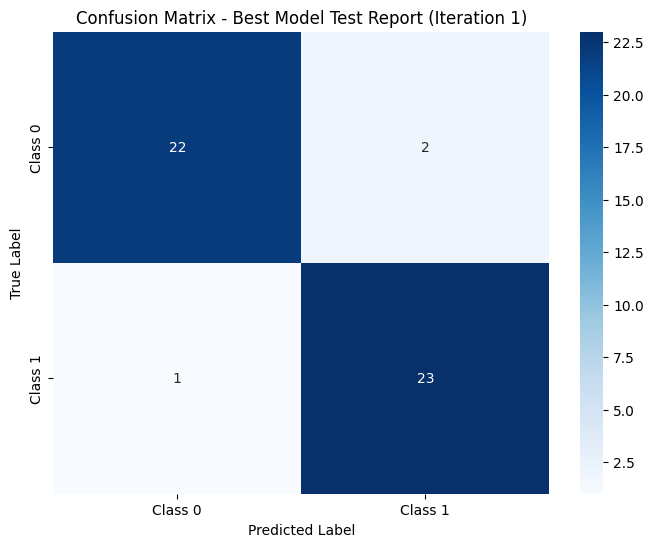


AUC Score: 0.9809


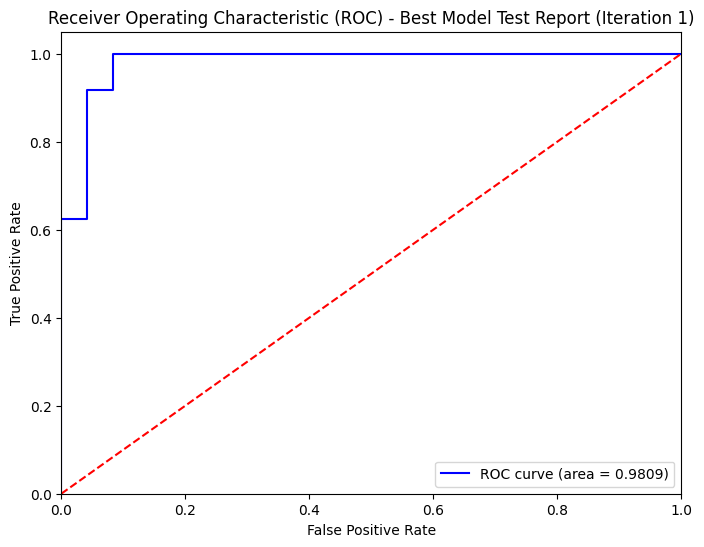

(array([[0.89583333, 0.9375    , 0.85416667, 0.77083333, 0.6875    ,
         0.66666667]]),
 array([[0.01091194, 0.00481772, 0.01367259, 0.00914907, 0.00275803,
         0.00853086]]),
 array([[0.94270833, 0.984375  , 0.98958333, 0.97916667, 0.93229167,
         0.88020833]]),
 array([[0.86688781, 0.68844652, 0.43726015, 0.65713143, 0.6668787 ,
         0.84756708]]))

In [31]:
file_path = '/content/drive/MyDrive/broadlearning/train_data_MLE_imputed_no_negative_med_imputed.csv'
data = pd.read_csv(file_path)

# Separate features and labels from the training data
full_features = data.drop(columns=['batch_label', 'label'])
full_labels = data['label']

# Perform 80/20 train-validation split on the original data
# 'test_size' is 0.2 (20% for validation), 'shuffle=True' to shuffle the data,
# and 'stratify=full_train_labels' to maintain class proportions.
train_features, test_features, train_labels, test_labels = train_test_split(
    full_features, full_labels, test_size=0.2, shuffle=True, stratify=full_train_labels, random_state=42
)

# Scale features
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels (fit only on training labels, transform both)
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)

encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameter Tuning ---
N1 = 10
N2 = 10
N3 = 100
L = 5
M1 = 50
s = 0.8
C = 2**-5

print('-------------------BLS_BASE---------------------------')
BLS(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3)

print('\n-------------------BLS_ENHANCE------------------------')
BLS_AddEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1)

print('\n-------------------BLS_FEATURE&ENHANCE----------------')
M2 = 50
M3 = 50
BLS_AddFeatureEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1, M2, M3)


### RAW data


In [32]:
file_path = '/content/drive/MyDrive/broadlearning/Train_data_New (1).csv'
data = pd.read_csv(file_path)

# Separate features and labels from the training data
full_features = data.drop(columns=['batch_label', 'label'])
full_labels = data['label']

# Perform 80/20 train-validation split on the original data
# 'test_size' is 0.2 (20% for validation), 'shuffle=True' to shuffle the data,
# and 'stratify=full_train_labels' to maintain class proportions.
train_features, test_features, train_labels, test_labels = train_test_split(
    full_features, full_labels, test_size=0.2, shuffle=True, stratify=full_train_labels, random_state=42
)

# Scale features
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels (fit only on training labels, transform both)
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)

encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameter Tuning ---
N1 = 10
N2 = 10
N3 = 100
L = 5
M1 = 50
s = 0.8
C = 2**-5

print('-------------------BLS_BASE---------------------------')
BLS(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3)

print('\n-------------------BLS_ENHANCE------------------------')
BLS_AddEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1)

print('\n-------------------BLS_FEATURE&ENHANCE----------------')
M2 = 50
M3 = 50
BLS_AddFeatureEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1, M2, M3)


KeyError: "['batch_label', 'label'] not found in axis"

In [ ]:
train_file_path = '/content/drive/MyDrive/broadlearning/Train_data_New (1).csv'
test_file_path = '/content/drive/MyDrive/broadlearning/Test_data_New.csv'

train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

train_features = train_data.drop(columns=['batch_label', 'label'])
test_features = test_data.drop(columns=['batch_label', 'label'])

train_labels = train_data['label']
test_labels = test_data['label']

scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)
encoder = OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)


# Hyperparameter Tuning
N1 = 10
N2 = 10
N3 = 100  # Reduced enhancement nodes
L = 5
M1 = 50
s = 0.8
C = 2**-5 # Increased regularization significantly

print('-------------------BLS_BASE---------------------------')
BLS(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3)

print('-------------------BLS_ENHANCE------------------------')
BLS_AddEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1)

print('-------------------BLS_FEATURE&ENHANCE----------------')
M2 = 50
M3 = 50
BLS_AddFeatureEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1, M2, M3)

### AE

-------------------BLS_BASE---------------------------
Training accurate is 92.70833333333334 %
Training time is  1.277719259262085 s
Testing accurate is 87.5 %
Testing time is  0.11343693733215332 s

-------------------BLS_ENHANCE------------------------
Training accurate is 92.708 %
Training time is  1.3123536109924316 s
Testing accurate is 87.5 %
Testing time is  0.05646657943725586 s
Incremental Training Accuracy is : 92.708  %
Incremental Testing Accuracy is :  87.5  %
Incremental Training Accuracy is : 92.708  %
Incremental Testing Accuracy is :  87.5  %
Incremental Training Accuracy is : 93.229  %
Incremental Testing Accuracy is :  87.5  %
Incremental Training Accuracy is : 93.229  %
Incremental Testing Accuracy is :  87.5  %
Incremental Training Accuracy is : 94.271  %
Incremental Testing Accuracy is :  89.583  %

-------------------BLS_FEATURE&ENHANCE----------------
Training accurate is 92.70833333333334 %
Training time is  1.4865343570709229 s
Testing accurate is 89.58333333

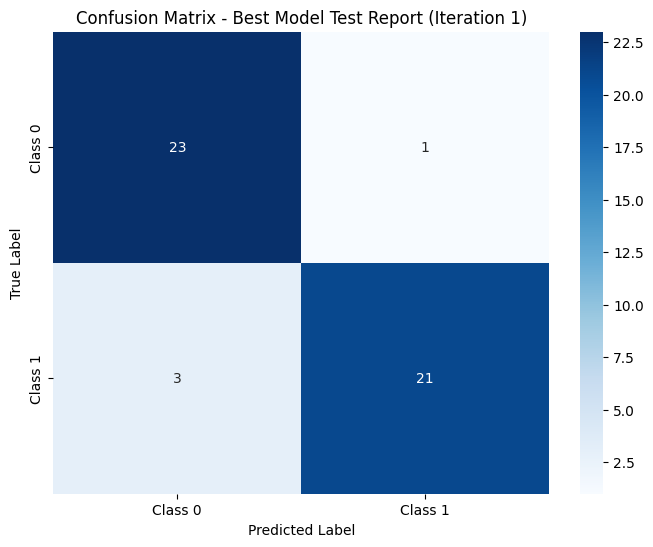


AUC Score: 0.9826


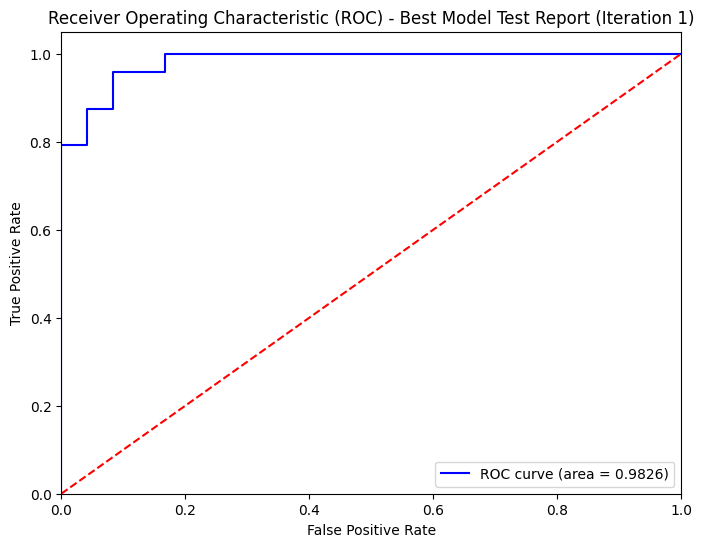

(array([[0.89583333, 0.91666667, 0.8125    , 0.8125    , 0.70833333,
         0.6875    ]]),
 array([[0.03709841, 0.00714636, 0.00594616, 0.00458002, 0.00541496,
         0.0179503 ]]),
 array([[0.92708333, 0.97916667, 1.        , 1.        , 0.94791667,
         0.921875  ]]),
 array([[1.48653436, 0.46216679, 0.58539319, 0.62430644, 1.11834002,
         2.20987415]]))

In [33]:
file_path = '/content/drive/MyDrive/broadlearning/train_data_AE_imputed.csv'
data = pd.read_csv(file_path)

# Separate features and labels from the training data
full_features = data.drop(columns=['batch_label', 'label'])
full_labels = data['label']

# Perform 80/20 train-validation split on the original data
# 'test_size' is 0.2 (20% for validation), 'shuffle=True' to shuffle the data,
# and 'stratify=full_train_labels' to maintain class proportions.
train_features, test_features, train_labels, test_labels = train_test_split(
    full_features, full_labels, test_size=0.2, shuffle=True, stratify=full_train_labels, random_state=42
)

# Scale features
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels (fit only on training labels, transform both)
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)

encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameter Tuning ---
N1 = 10
N2 = 10
N3 = 100
L = 5
M1 = 50
s = 0.8
C = 2**-5

print('-------------------BLS_BASE---------------------------')
BLS(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3)

print('\n-------------------BLS_ENHANCE------------------------')
BLS_AddEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1)

print('\n-------------------BLS_FEATURE&ENHANCE----------------')
M2 = 50
M3 = 50
BLS_AddFeatureEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1, M2, M3)

### LeftCensored



-------------------BLS_BASE---------------------------
Training accurate is 92.1875 %
Training time is  1.2439749240875244 s
Testing accurate is 89.58333333333334 %
Testing time is  0.04950141906738281 s

-------------------BLS_ENHANCE------------------------
Training accurate is 92.188 %
Training time is  2.6150753498077393 s
Testing accurate is 89.583 %
Testing time is  0.047150611877441406 s
Incremental Training Accuracy is : 92.188  %
Incremental Testing Accuracy is :  89.583  %
Incremental Training Accuracy is : 92.188  %
Incremental Testing Accuracy is :  89.583  %
Incremental Training Accuracy is : 92.708  %
Incremental Testing Accuracy is :  89.583  %
Incremental Training Accuracy is : 92.708  %
Incremental Testing Accuracy is :  89.583  %
Incremental Training Accuracy is : 92.708  %
Incremental Testing Accuracy is :  89.583  %

-------------------BLS_FEATURE&ENHANCE----------------
Training accurate is 92.1875 %
Training time is  1.5180883407592773 s
Testing accurate is 89.583

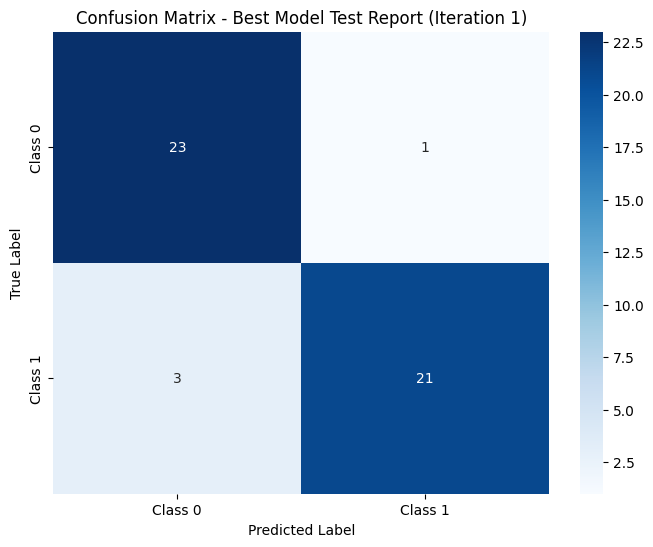


AUC Score: 0.9896


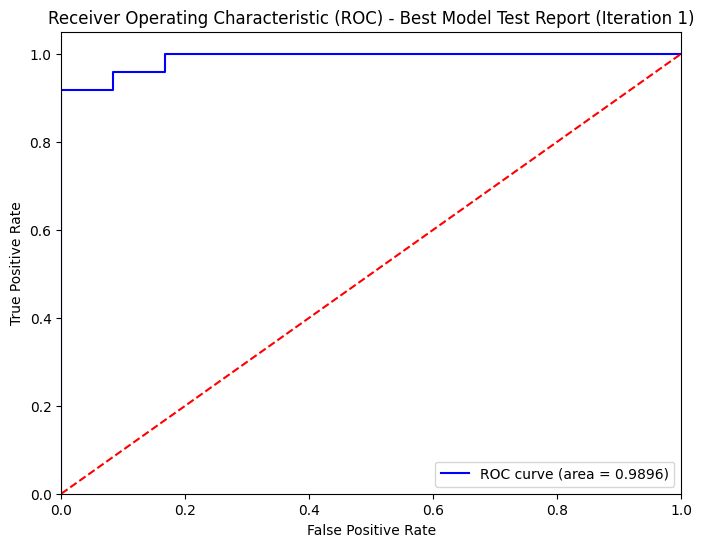

(array([[0.89583333, 0.91666667, 0.91666667, 0.85416667, 0.77083333,
         0.75      ]]),
 array([[0.03593016, 0.01481676, 0.0126102 , 0.00260401, 0.02839947,
         0.002841  ]]),
 array([[0.921875  , 0.953125  , 0.97916667, 0.98958333, 0.96354167,
         0.92708333]]),
 array([[1.51808834, 1.706918  , 1.38935685, 0.70417285, 0.66040921,
         0.81663609]]))

In [34]:
file_path = '/content/drive/MyDrive/broadlearning/train_data_LeftCensored_imputed.csv'
data = pd.read_csv(file_path)

# Separate features and labels from the training data
full_features = data.drop(columns=['batch_label', 'label'])
full_labels = data['label']

# Perform 80/20 train-validation split on the original data
# 'test_size' is 0.2 (20% for validation), 'shuffle=True' to shuffle the data,
# and 'stratify=full_train_labels' to maintain class proportions.
train_features, test_features, train_labels, test_labels = train_test_split(
    full_features, full_labels, test_size=0.2, shuffle=True, stratify=full_train_labels, random_state=42
)

# Scale features
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels (fit only on training labels, transform both)
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)

encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameter Tuning ---
N1 = 10
N2 = 10
N3 = 100
L = 5
M1 = 50
s = 0.8
C = 2**-5

print('-------------------BLS_BASE---------------------------')
BLS(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3)

print('\n-------------------BLS_ENHANCE------------------------')
BLS_AddEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1)

print('\n-------------------BLS_FEATURE&ENHANCE----------------')
M2 = 50
M3 = 50
BLS_AddFeatureEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1, M2, M3)

### KNN


-------------------BLS_BASE---------------------------
Training accurate is 94.27083333333334 %
Training time is  1.0076394081115723 s
Testing accurate is 87.5 %
Testing time is  0.009624958038330078 s

-------------------BLS_ENHANCE------------------------
Training accurate is 94.271 %
Training time is  1.2077014446258545 s
Testing accurate is 87.5 %
Testing time is  0.005402088165283203 s
Incremental Training Accuracy is : 94.271  %
Incremental Testing Accuracy is :  87.5  %
Incremental Training Accuracy is : 94.792  %
Incremental Testing Accuracy is :  87.5  %
Incremental Training Accuracy is : 94.792  %
Incremental Testing Accuracy is :  87.5  %
Incremental Training Accuracy is : 94.792  %
Incremental Testing Accuracy is :  87.5  %
Incremental Training Accuracy is : 95.833  %
Incremental Testing Accuracy is :  85.417  %

-------------------BLS_FEATURE&ENHANCE----------------
Training accurate is 94.79166666666666 %
Training time is  3.5295205116271973 s
Testing accurate is 83.33333

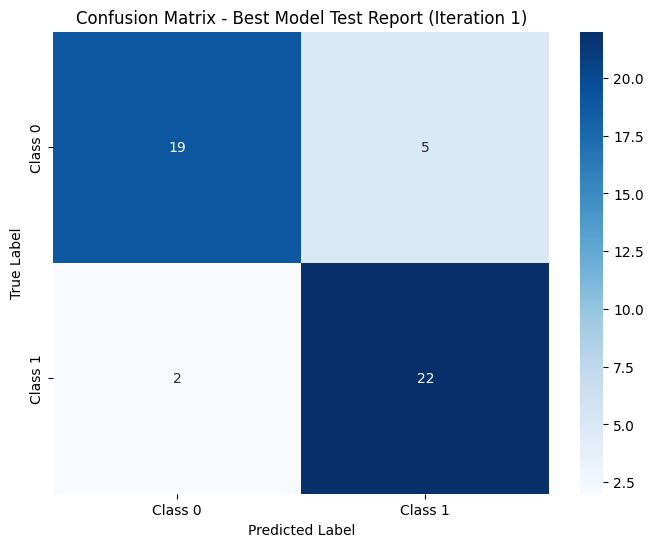


AUC Score: 0.9358


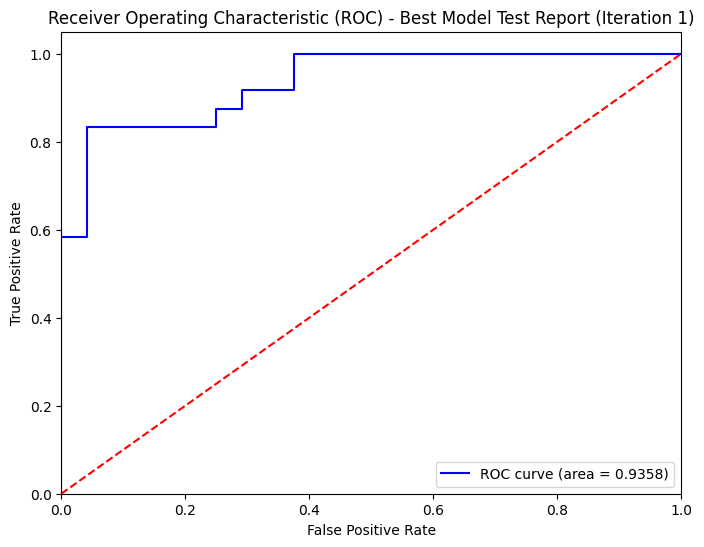

(array([[0.83333333, 0.85416667, 0.85416667, 0.8125    , 0.72916667,
         0.72916667]]),
 array([[0.06102037, 0.01414561, 0.00257444, 0.00266814, 0.00303245,
         0.00750923]]),
 array([[0.94791667, 0.98958333, 0.98958333, 0.984375  , 0.94791667,
         0.90625   ]]),
 array([[3.52952051, 1.01377535, 0.55230403, 0.52999806, 0.64685369,
         1.18734288]]))

In [35]:
file_path = '/content/drive/MyDrive/broadlearning/train_data_KNN_imputed.csv'
data = pd.read_csv(file_path)

# Separate features and labels from the training data
full_features = data.drop(columns=['batch_label', 'label'])
full_labels = data['label']

# Perform 80/20 train-validation split on the original data
# 'test_size' is 0.2 (20% for validation), 'shuffle=True' to shuffle the data,
# and 'stratify=full_train_labels' to maintain class proportions.
train_features, test_features, train_labels, test_labels = train_test_split(
    full_features, full_labels, test_size=0.2, shuffle=True, stratify=full_train_labels, random_state=42
)

# Scale features
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels (fit only on training labels, transform both)
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)

encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameter Tuning ---
N1 = 10
N2 = 10
N3 = 100
L = 5
M1 = 50
s = 0.8
C = 2**-5

print('-------------------BLS_BASE---------------------------')
BLS(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3)

print('\n-------------------BLS_ENHANCE------------------------')
BLS_AddEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1)

print('\n-------------------BLS_FEATURE&ENHANCE----------------')
M2 = 50
M3 = 50
BLS_AddFeatureEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1, M2, M3)

### SVD

-------------------BLS_BASE---------------------------
Training accurate is 94.27083333333334 %
Training time is  0.9844551086425781 s
Testing accurate is 89.58333333333334 %
Testing time is  0.00980997085571289 s

-------------------BLS_ENHANCE------------------------
Training accurate is 94.271 %
Training time is  1.9182286262512207 s
Testing accurate is 89.583 %
Testing time is  0.050423622131347656 s
Incremental Training Accuracy is : 94.271  %
Incremental Testing Accuracy is :  89.583  %
Incremental Training Accuracy is : 94.271  %
Incremental Testing Accuracy is :  89.583  %
Incremental Training Accuracy is : 93.75  %
Incremental Testing Accuracy is :  87.5  %
Incremental Training Accuracy is : 93.75  %
Incremental Testing Accuracy is :  87.5  %
Incremental Training Accuracy is : 94.271  %
Incremental Testing Accuracy is :  93.75  %

-------------------BLS_FEATURE&ENHANCE----------------
Training accurate is 95.3125 %
Training time is  3.1844420433044434 s
Testing accurate is 91.

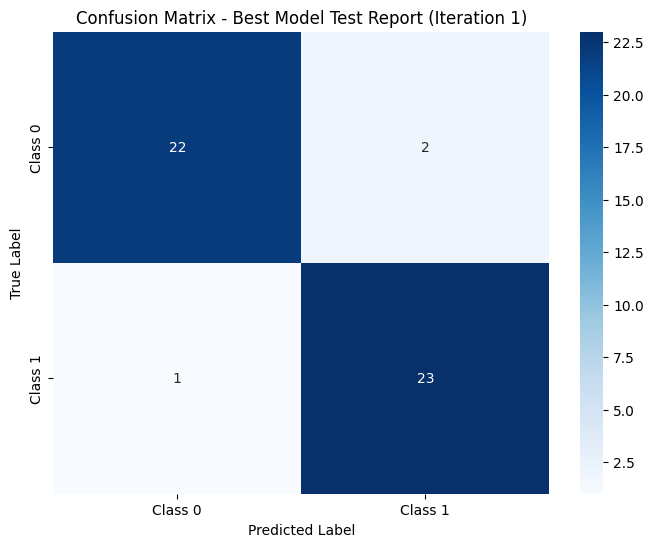


AUC Score: 0.9792


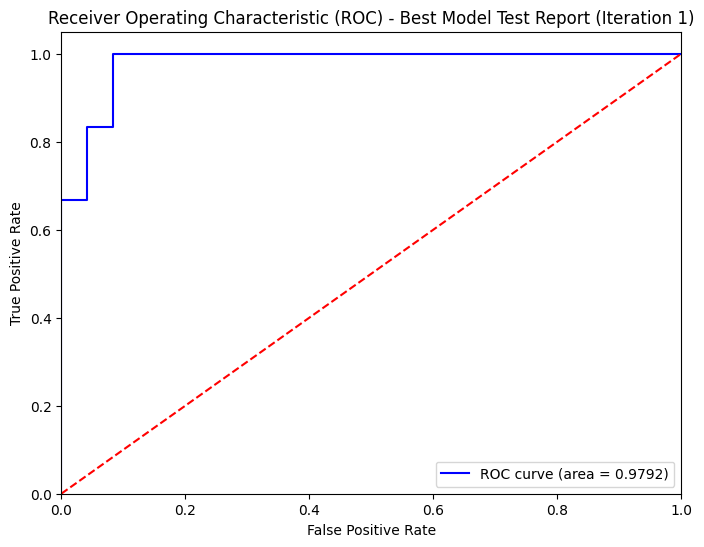

(array([[0.91666667, 0.9375    , 0.89583333, 0.79166667, 0.75      ,
         0.6875    ]]),
 array([[0.01442266, 0.01074433, 0.00343561, 0.02633238, 0.01156759,
         0.00266719]]),
 array([[0.953125  , 0.96354167, 0.984375  , 0.98958333, 0.953125  ,
         0.92708333]]),
 array([[3.18444204, 0.80486512, 0.85524392, 0.84379601, 0.57071853,
         0.51845765]]))

In [36]:
file_path = '/content/drive/MyDrive/broadlearning/Train_data_Imputed_SVD_no_negative.csv'
data = pd.read_csv(file_path)

# Separate features and labels from the training data
full_features = data.drop(columns=['batch_label', 'label'])
full_labels = data['label']

# Perform 80/20 train-validation split on the original data
# 'test_size' is 0.2 (20% for validation), 'shuffle=True' to shuffle the data,
# and 'stratify=full_train_labels' to maintain class proportions.
train_features, test_features, train_labels, test_labels = train_test_split(
    full_features, full_labels, test_size=0.2, shuffle=True, stratify=full_train_labels, random_state=42
)

# Scale features
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels (fit only on training labels, transform both)
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)

encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameter Tuning ---
N1 = 10
N2 = 10
N3 = 100
L = 5
M1 = 50
s = 0.8
C = 2**-5

print('-------------------BLS_BASE---------------------------')
BLS(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3)

print('\n-------------------BLS_ENHANCE------------------------')
BLS_AddEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1)

print('\n-------------------BLS_FEATURE&ENHANCE----------------')
M2 = 50
M3 = 50
BLS_AddFeatureEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1, M2, M3)

### VAE

-------------------BLS_BASE---------------------------
Training accurate is 89.58333333333334 %
Training time is  1.7801599502563477 s
Testing accurate is 91.66666666666666 %
Testing time is  0.02506399154663086 s

-------------------BLS_ENHANCE------------------------
Training accurate is 89.062 %
Training time is  1.007460117340088 s
Testing accurate is 91.667 %
Testing time is  0.018728256225585938 s
Incremental Training Accuracy is : 89.062  %
Incremental Testing Accuracy is :  91.667  %
Incremental Training Accuracy is : 89.062  %
Incremental Testing Accuracy is :  91.667  %
Incremental Training Accuracy is : 90.625  %
Incremental Testing Accuracy is :  91.667  %
Incremental Training Accuracy is : 90.625  %
Incremental Testing Accuracy is :  91.667  %
Incremental Training Accuracy is : 92.708  %
Incremental Testing Accuracy is :  91.667  %

-------------------BLS_FEATURE&ENHANCE----------------
Training accurate is 92.70833333333334 %
Training time is  1.4582924842834473 s
Testing

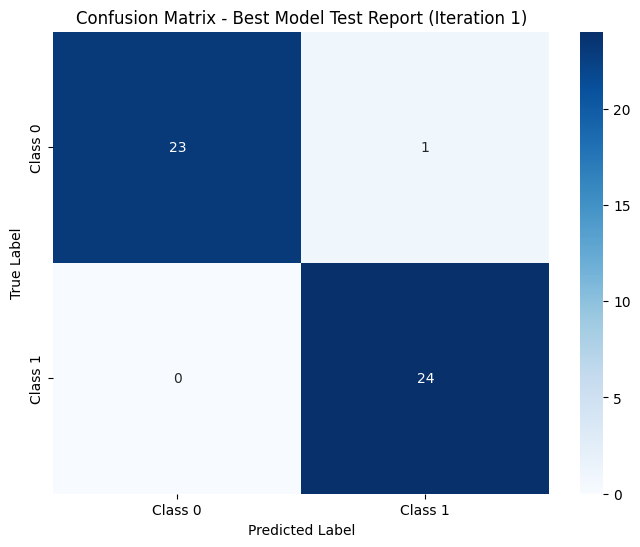


AUC Score: 0.9948


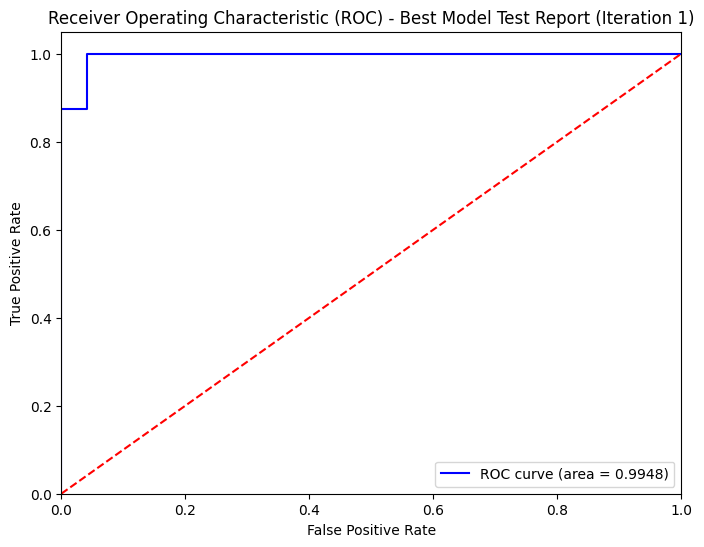

(array([[0.875     , 0.97916667, 0.91666667, 0.83333333, 0.77083333,
         0.77083333]]),
 array([[0.01021767, 0.00254774, 0.00257325, 0.00255847, 0.00624514,
         0.01143479]]),
 array([[0.92708333, 0.9375    , 0.953125  , 0.93229167, 0.90625   ,
         0.875     ]]),
 array([[1.45829248, 0.80413461, 1.65857506, 0.85533118, 0.51794529,
         0.74460721]]))

In [37]:
file_path = '/content/drive/MyDrive/broadlearning/ImputedVAETrain_common.csv'
data = pd.read_csv(file_path)

# Separate features and labels from the training data
full_features = data.drop(columns=['batch_label', 'label'])
full_labels = data['label']

# Perform 80/20 train-validation split on the original data
# 'test_size' is 0.2 (20% for validation), 'shuffle=True' to shuffle the data,
# and 'stratify=full_train_labels' to maintain class proportions.
train_features, test_features, train_labels, test_labels = train_test_split(
    full_features, full_labels, test_size=0.2, shuffle=True, stratify=full_train_labels, random_state=42
)

# Scale features
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels (fit only on training labels, transform both)
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)

encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameter Tuning ---
N1 = 10
N2 = 10
N3 = 100
L = 5
M1 = 50
s = 0.8
C = 2**-5

print('-------------------BLS_BASE---------------------------')
BLS(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3)

print('\n-------------------BLS_ENHANCE------------------------')
BLS_AddEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1)

print('\n-------------------BLS_FEATURE&ENHANCE----------------')
M2 = 50
M3 = 50
BLS_AddFeatureEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1, M2, M3)

### DAE


-------------------BLS_BASE---------------------------
Training accurate is 91.14583333333334 %
Training time is  1.5343234539031982 s
Testing accurate is 89.58333333333334 %
Testing time is  0.021670818328857422 s

-------------------BLS_ENHANCE------------------------
Training accurate is 91.146 %
Training time is  1.3008625507354736 s
Testing accurate is 91.667 %
Testing time is  0.019533395767211914 s
Incremental Training Accuracy is : 91.146  %
Incremental Testing Accuracy is :  91.667  %
Incremental Training Accuracy is : 91.146  %
Incremental Testing Accuracy is :  91.667  %
Incremental Training Accuracy is : 93.75  %
Incremental Testing Accuracy is :  91.667  %
Incremental Training Accuracy is : 93.75  %
Incremental Testing Accuracy is :  91.667  %
Incremental Training Accuracy is : 94.271  %
Incremental Testing Accuracy is :  89.583  %

-------------------BLS_FEATURE&ENHANCE----------------
Training accurate is 94.27083333333334 %
Training time is  0.9545130729675293 s
Testing

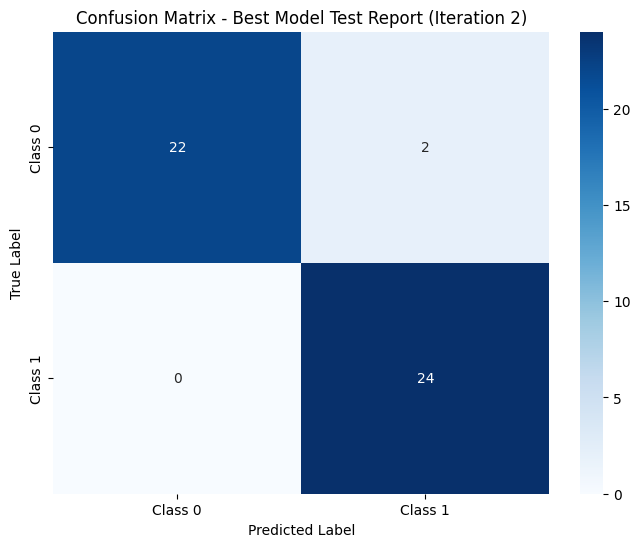


AUC Score: 0.9913


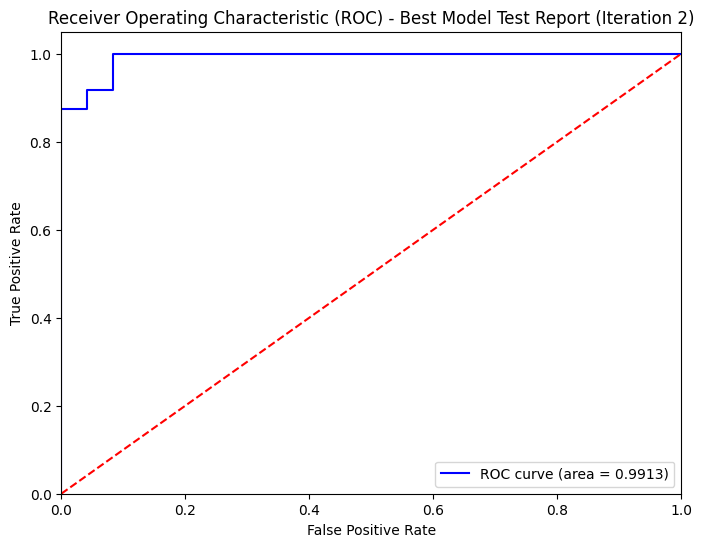

(array([[0.91666667, 0.9375    , 0.95833333, 0.9375    , 0.875     ,
         0.8125    ]]),
 array([[0.01623797, 0.02587795, 0.00463581, 0.28161454, 0.10479307,
         0.10867691]]),
 array([[0.94270833, 0.95833333, 0.96354167, 0.92708333, 0.890625  ,
         0.84895833]]),
 array([[0.95451307, 0.65041924, 0.6444838 , 0.97955012, 1.37267566,
         1.77227449]]))

In [38]:
file_path = '/content/drive/MyDrive/broadlearning/ImputedDAETrain_common.csv'
data = pd.read_csv(file_path)

# Separate features and labels from the training data
full_features = data.drop(columns=['batch_label', 'label'])
full_labels = data['label']

# Perform 80/20 train-validation split on the original data
# 'test_size' is 0.2 (20% for validation), 'shuffle=True' to shuffle the data,
# and 'stratify=full_train_labels' to maintain class proportions.
train_features, test_features, train_labels, test_labels = train_test_split(
    full_features, full_labels, test_size=0.2, shuffle=True, stratify=full_train_labels, random_state=42
)

# Scale features
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels (fit only on training labels, transform both)
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)

encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameter Tuning ---
N1 = 10
N2 = 10
N3 = 100
L = 5
M1 = 50
s = 0.8
C = 2**-5

print('-------------------BLS_BASE---------------------------')
BLS(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3)

print('\n-------------------BLS_ENHANCE------------------------')
BLS_AddEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1)

print('\n-------------------BLS_FEATURE&ENHANCE----------------')
M2 = 50
M3 = 50
BLS_AddFeatureEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1, M2, M3)

### CFT


-------------------BLS_BASE---------------------------
Training accurate is 90.625 %
Training time is  0.981564998626709 s
Testing accurate is 89.58333333333334 %
Testing time is  0.12868118286132812 s

-------------------BLS_ENHANCE------------------------
Training accurate is 90.625 %
Training time is  1.2295441627502441 s
Testing accurate is 89.583 %
Testing time is  0.012695789337158203 s
Incremental Training Accuracy is : 90.625  %
Incremental Testing Accuracy is :  89.583  %
Incremental Training Accuracy is : 90.625  %
Incremental Testing Accuracy is :  89.583  %
Incremental Training Accuracy is : 91.667  %
Incremental Testing Accuracy is :  89.583  %
Incremental Training Accuracy is : 91.667  %
Incremental Testing Accuracy is :  89.583  %
Incremental Training Accuracy is : 92.708  %
Incremental Testing Accuracy is :  87.5  %

-------------------BLS_FEATURE&ENHANCE----------------
Training accurate is 90.625 %
Training time is  1.039470911026001 s
Testing accurate is 87.5 %
Testi

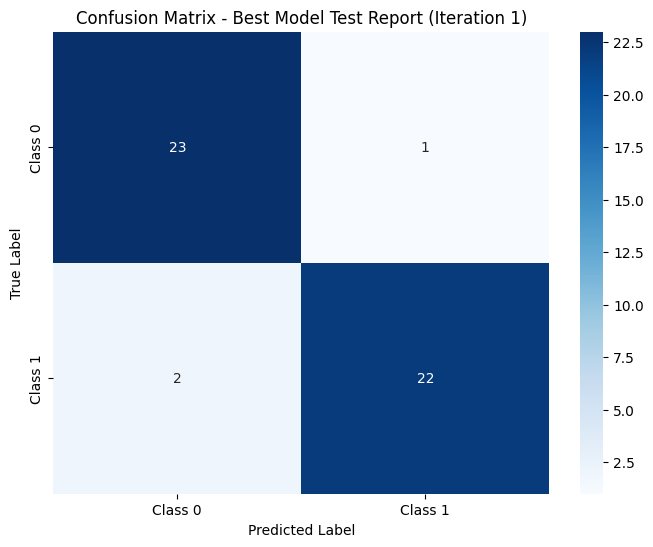


AUC Score: 0.9757


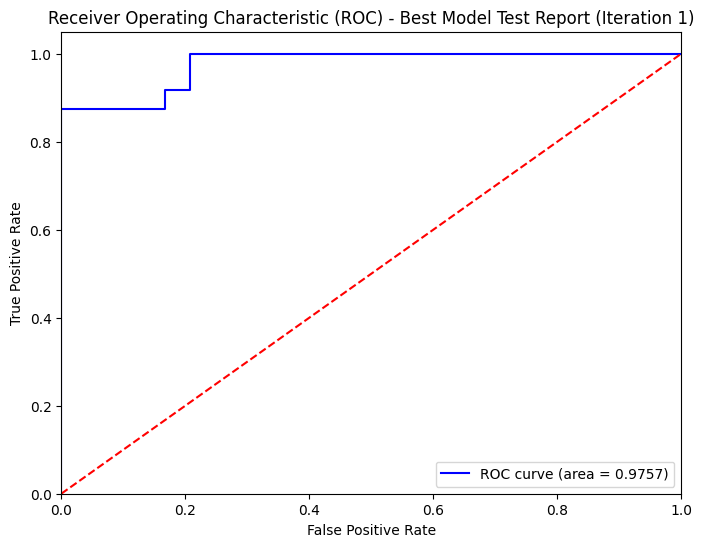

(array([[0.875     , 0.9375    , 0.875     , 0.83333333, 0.79166667,
         0.79166667]]),
 array([[0.01626635, 0.00531292, 0.00226951, 0.00620437, 0.01832604,
         0.01327872]]),
 array([[0.90625   , 0.94270833, 0.95833333, 0.94791667, 0.91145833,
         0.890625  ]]),
 array([[1.03947091, 0.69446564, 0.58187604, 2.1836257 , 1.38861012,
         0.97062683]]))

In [39]:
file_path = '/content/drive/MyDrive/broadlearning/Imputed_CFT_Train_common.csv'
data = pd.read_csv(file_path)

# Separate features and labels from the training data
full_features = data.drop(columns=['batch_label', 'label'])
full_labels = data['label']

# Perform 80/20 train-validation split on the original data
# 'test_size' is 0.2 (20% for validation), 'shuffle=True' to shuffle the data,
# and 'stratify=full_train_labels' to maintain class proportions.
train_features, test_features, train_labels, test_labels = train_test_split(
    full_features, full_labels, test_size=0.2, shuffle=True, stratify=full_train_labels, random_state=42
)

# Scale features
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels (fit only on training labels, transform both)
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)

encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameter Tuning ---
N1 = 10
N2 = 10
N3 = 100
L = 5
M1 = 50
s = 0.8
C = 2**-5

print('-------------------BLS_BASE---------------------------')
BLS(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3)

print('\n-------------------BLS_ENHANCE------------------------')
BLS_AddEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1)

print('\n-------------------BLS_FEATURE&ENHANCE----------------')
M2 = 50
M3 = 50
BLS_AddFeatureEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1, M2, M3)

### BPCA


-------------------BLS_BASE---------------------------
Training accurate is 92.1875 %
Training time is  1.0656137466430664 s
Testing accurate is 91.66666666666666 %
Testing time is  0.006866455078125 s

-------------------BLS_ENHANCE------------------------
Training accurate is 92.188 %
Training time is  2.9916656017303467 s
Testing accurate is 91.667 %
Testing time is  0.033663034439086914 s
Incremental Training Accuracy is : 92.188  %
Incremental Testing Accuracy is :  91.667  %
Incremental Training Accuracy is : 92.188  %
Incremental Testing Accuracy is :  91.667  %
Incremental Training Accuracy is : 93.75  %
Incremental Testing Accuracy is :  91.667  %
Incremental Training Accuracy is : 93.75  %
Incremental Testing Accuracy is :  91.667  %
Incremental Training Accuracy is : 93.75  %
Incremental Testing Accuracy is :  91.667  %

-------------------BLS_FEATURE&ENHANCE----------------
Training accurate is 93.75 %
Training time is  2.0915820598602295 s
Testing accurate is 89.5833333333

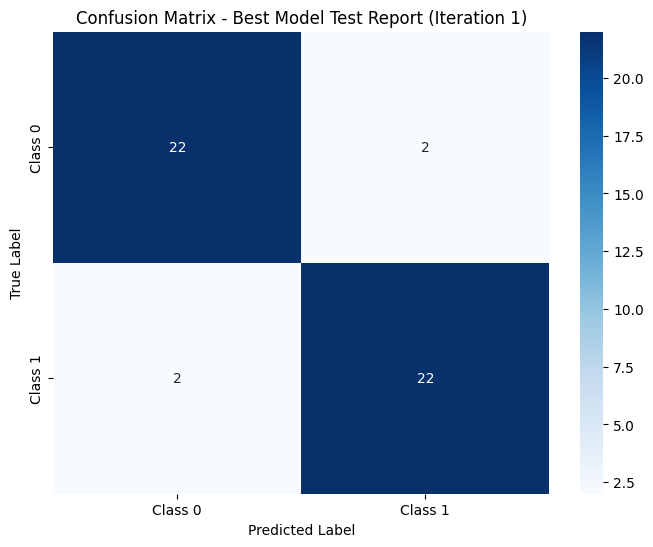


AUC Score: 0.9722


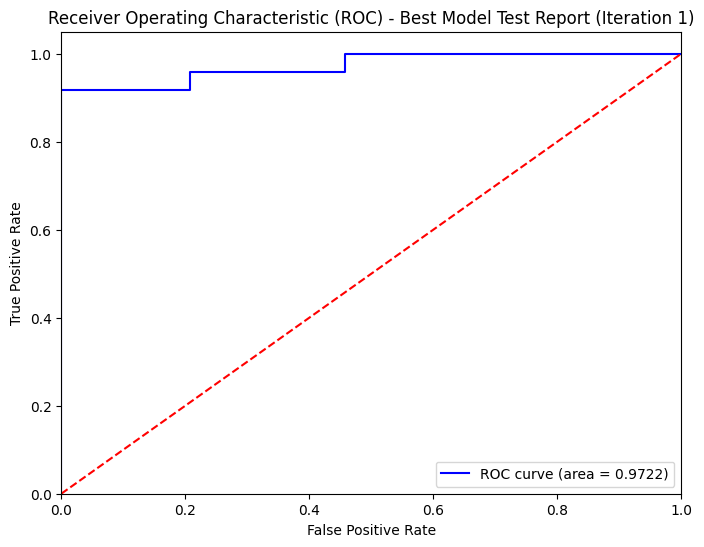

(array([[0.89583333, 0.91666667, 0.79166667, 0.72916667, 0.6875    ,
         0.66666667]]),
 array([[0.01583672, 0.01076555, 0.00473022, 0.01275063, 0.00581312,
         0.00251722]]),
 array([[0.9375    , 0.98958333, 0.97916667, 0.96875   , 0.921875  ,
         0.890625  ]]),
 array([[2.09158206, 0.56248856, 0.54529905, 0.47118831, 0.5234499 ,
         0.57041812]]))

In [40]:
file_path = '/content/drive/MyDrive/broadlearning/train_data_BPCA_imputed.csv'
data = pd.read_csv(file_path)

# Separate features and labels from the training data
full_features = data.drop(columns=['batch_label', 'label'])
full_labels = data['label']

# Perform 80/20 train-validation split on the original data
# 'test_size' is 0.2 (20% for validation), 'shuffle=True' to shuffle the data,
# and 'stratify=full_train_labels' to maintain class proportions.
train_features, test_features, train_labels, test_labels = train_test_split(
    full_features, full_labels, test_size=0.2, shuffle=True, stratify=full_train_labels, random_state=42
)

# Scale features
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels (fit only on training labels, transform both)
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)

encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameter Tuning ---
N1 = 10
N2 = 10
N3 = 100
L = 5
M1 = 50
s = 0.8
C = 2**-5

print('-------------------BLS_BASE---------------------------')
BLS(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3)

print('\n-------------------BLS_ENHANCE------------------------')
BLS_AddEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1)

print('\n-------------------BLS_FEATURE&ENHANCE----------------')
M2 = 50
M3 = 50
BLS_AddFeatureEnhanceNodes(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot, s, C, N1, N2, N3, L, M1, M2, M3)

# Fuzzy BLS


In [49]:
import numpy as np
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, accuracy_score
from numpy import random
from scipy import linalg as LA
import time
import pandas as pd
import matplotlib.pyplot as plt


def tansig(x):
    return (2 / (1 + np.exp(-2 * x))) - 1

def pinv(A, reg):
    A = np.asarray(A)
    return np.linalg.inv(A.T @ A + reg * np.eye(A.shape[1])) @ A.T

def shrinkage(a, b):
    z = np.maximum(a - b, 0) - np.maximum( -a - b, 0)
    return z

def sparse_bls(A, b):
    lam = 0.001
    itrs = 50

    AA = A.T.dot(A)
    m = A.shape[1]
    n = b.shape[1]

    wk = np.zeros([m, n])
    ok = np.zeros([m, n])
    uk = np.zeros([m, n])

    L1 = np.linalg.inv(AA + np.eye(m))
    L2 = L1.dot(A.T).dot(b)

    for i in range(itrs):
        ck = L2 + L1.dot(ok - uk)
        ok = shrinkage(ck + uk, lam)
        uk = uk + ck - ok
        wk = ok
    return wk

In [50]:
def evaluate_model(y_true_onehot, y_pred_score, model_name):
    y_true_onehot = np.asarray(y_true_onehot)
    y_pred_score = np.asarray(y_pred_score)

    y_true_labels = np.argmax(y_true_onehot, axis=1)
    # Predicted labels are determined from the raw scores
    y_pred_labels = np.argmax(y_pred_score, axis=1)

    print(f"\n--- {model_name} Evaluation ---")

    accuracy = accuracy_score(y_true_labels, y_pred_labels)
    print(f"Overall Accuracy: {accuracy * 100:.3f}%")

    print("\nClassification Report:")
    print(classification_report(y_true_labels, y_pred_labels, target_names=['Class 0', 'Class 1']))

    # Calculate and print the Confusion Matrix
    cm = confusion_matrix(y_true_labels, y_pred_labels)
    print("\nConfusion Matrix:")
    print(cm)

    # Plot the Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Plot the ROC Curve
    try:
        # Use raw scores for the ROC curve
        auc_score = roc_auc_score(y_true_labels, y_pred_score[:, 1])
        print(f"\nAUC Score: {auc_score:.4f}")

        fpr, tpr, thresholds = roc_curve(y_true_labels, y_pred_score[:, 1])
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {auc_score:.4f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) - {model_name}')
        plt.legend(loc="lower right")
        plt.show()
    except ValueError as e:
        print(f"\nCould not calculate ROC AUC: {e}")

    return accuracy

### FBLS function

In [51]:
def fuzzy_bls_train(train_x, train_y, test_x, test_y, Alpha, WeightEnhan, s, C, NumRule, NumFuzz):
    std = 1
    start_time_train = time.time()
    y_fuzzy_features = np.zeros((train_x.shape[0], NumFuzz * NumRule))

    CENTER = []
    PS = []

    for i in range(NumFuzz):
        b1 = Alpha[i]
        kmeans = KMeans(n_clusters=NumRule, random_state=i, n_init=10)
        kmeans.fit(train_x)
        center = kmeans.cluster_centers_

        t_y_subsystem = np.zeros((train_x.shape[0], NumRule))

        for j in range(train_x.shape[0]):
            diff_sq = (np.tile(train_x[j,:], (NumRule, 1)) - center)**2
            MF_val = np.exp(-np.sum(diff_sq, axis=1) / std)

            if np.sum(MF_val) == 0:
                MF_val_normalized = np.ones_like(MF_val) / NumRule
            else:
                MF_val_normalized = MF_val / np.sum(MF_val)

            then_part_output = train_x[j,:].reshape(1, -1) @ b1
            t_y_subsystem[j,:] = MF_val_normalized * then_part_output.flatten()

        CENTER.append(center)

        scaler_subsystem = preprocessing.MinMaxScaler(feature_range=(0, 1))
        T1_scaled = scaler_subsystem.fit_transform(t_y_subsystem)
        PS.append(scaler_subsystem)

        y_fuzzy_features[:, NumRule*(i):NumRule*(i+1)] = T1_scaled

    H2 = np.hstack([y_fuzzy_features, 0.1 * np.ones((y_fuzzy_features.shape[0], 1))])

    T2_raw = H2 @ WeightEnhan
    l2 = s / np.max(T2_raw)
    T2_enhanced = tansig(T2_raw * l2)

    T3_final_input = np.hstack([y_fuzzy_features, T2_enhanced])

    beta = pinv(T3_final_input, C) @ train_y

    Training_time = time.time() - start_time_train
    print('Training has been finished!')
    print(f'The Total Training Time is : {Training_time:.3f} seconds')

    NetoutTrain = T3_final_input @ beta

    train_y_flat = np.argmax(train_y, axis=1)
    NetoutTrain_flat = np.argmax(NetoutTrain, axis=1)
    TrainingAccuracy = accuracy_score(train_y_flat, NetoutTrain_flat)
    print(f'Training Accuracy is : {TrainingAccuracy * 100:.3f} %')

    # --- Testing Phase ---
    start_time_test = time.time()

    yy1_fuzzy_features = np.zeros((test_x.shape[0], NumFuzz * NumRule))

    for i in range(NumFuzz):
        b1 = Alpha[i]
        center = CENTER[i]

        t_y_subsystem_test = np.zeros((test_x.shape[0], NumRule))

        for j in range(test_x.shape[0]):
            diff_sq = (np.tile(test_x[j,:], (NumRule, 1)) - center)**2
            MF_val = np.exp(-np.sum(diff_sq, axis=1) / std)

            if np.sum(MF_val) == 0:
                MF_val_normalized = np.ones_like(MF_val) / NumRule
            else:
                MF_val_normalized = MF_val / np.sum(MF_val)

            then_part_output = test_x[j,:].reshape(1, -1) @ b1
            t_y_subsystem_test[j,:] = MF_val_normalized * then_part_output.flatten()

        scaler_subsystem_test = PS[i]
        TT1_scaled = scaler_subsystem_test.transform(t_y_subsystem_test)

        yy1_fuzzy_features[:, NumRule*(i):NumRule*(i+1)] = TT1_scaled

    HH2_test = np.hstack([yy1_fuzzy_features, 0.1 * np.ones((yy1_fuzzy_features.shape[0], 1))])

    TT2_enhanced_test = tansig(HH2_test @ WeightEnhan * l2)

    TT3_final_input_test = np.hstack([yy1_fuzzy_features, TT2_enhanced_test])

    NetoutTest = TT3_final_input_test @ beta

    Testing_time = time.time() - start_time_test
    print('Testing has been finished!')
    print(f'The Total Testing Time is : {Testing_time:.3f} seconds')

    # Evaluate testing accuracy (using the original NetoutTest)
    TestingAccuracy = evaluate_model(test_y, NetoutTest, "Testing Set")

    return NetoutTest, Training_time, Testing_time, TrainingAccuracy, TestingAccuracy

## Experiments


In [43]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

Mounted at /content/drive


### CFT

Total data loaded: 240 samples
Training set size: 192 samples (80%)
Testing set size: 48 samples (20%)
Training has been finished!
The Total Training Time is : 3.319 seconds
Training Accuracy is : 65.104 %
Testing has been finished!
The Total Testing Time is : 0.038 seconds

--- Testing Set Evaluation ---
Overall Accuracy: 56.250%

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.55      0.75      0.63        24
     Class 1       0.60      0.38      0.46        24

    accuracy                           0.56        48
   macro avg       0.57      0.56      0.55        48
weighted avg       0.57      0.56      0.55        48


Confusion Matrix:
[[18  6]
 [15  9]]


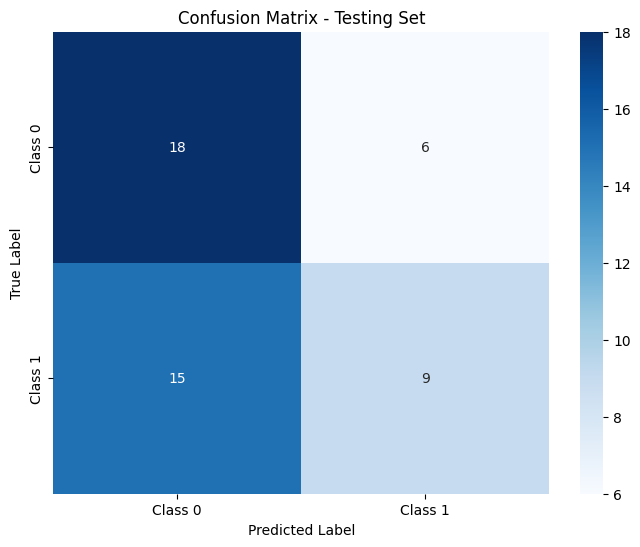


AUC Score: 0.5920


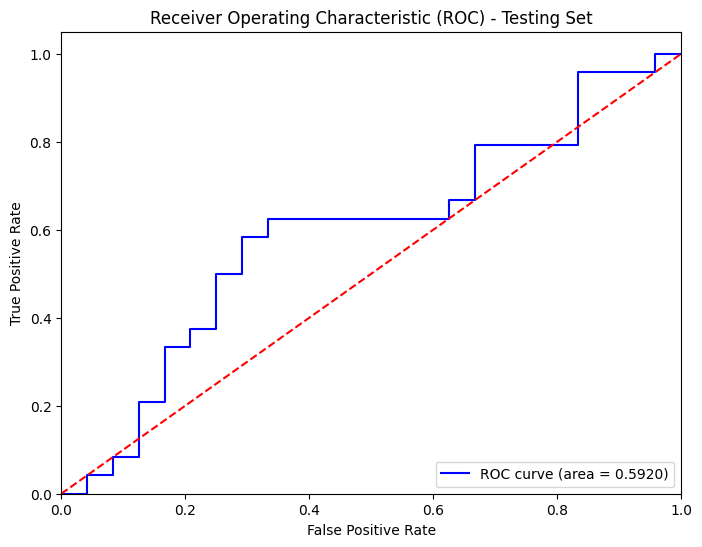


--- Final Run Results ---
{'C': 0.01, 'NumRule': 2, 'NumFuzz': 6, 'NumEnhan': 20, 'TrainingAccuracy': 0.6510416666666666, 'TestingAccuracy': 0.5625, 'TotalTime': 3.3566620349884033}


In [52]:
file_path = '/content/drive/MyDrive/broadlearning/Imputed_CFT_Train_common.csv'

# Load the data
full_data = pd.read_csv(train_file_path)

# Separate features and labels from the full dataset
features = full_data.drop(columns=['batch_label', 'label'])
labels = full_data['label']

# Split the full dataset into an 80/20 train/test (validation) set.
# The `stratify` parameter ensures the class distribution in both sets is the same.
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42
)

print(f"Total data loaded: {len(full_data)} samples")
print(f"Training set size: {len(train_features)} samples (80%)")
print(f"Testing set size: {len(test_features)} samples (20%)")

# Scale features (fit only on training data, transform both train and test)
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)
encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameters for FuzzyBLS ---
C = 0.01      # Regularization parameter
s = 0.8       # Shrinkage parameter
NumRule = 2   # Number of fuzzy rules (clusters) per fuzzy subsystem
NumFuzz = 6   # Number of fuzzy subsystems
NumEnhan = 20 # Number of enhancement nodes

# Initialize Alpha and WeightEnhan for each run to ensure fresh weights
Alpha = []
for i in range(NumFuzz):
    Alpha.append(2 * random.rand(train_features_scaled.shape[1], NumRule) - 1)
WeightEnhan = 2 * random.rand(NumFuzz * NumRule + 1, NumEnhan) - 1

# Call the fuzzy_bls_train function
NetoutTest, Training_time, Testing_time, TrainingAccuracy, TestingAccuracy = \
    fuzzy_bls_train(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot,
                    Alpha, WeightEnhan, s, C, NumRule, NumFuzz)

# Store results
results = {
    'C': C,
    'NumRule': NumRule,
    'NumFuzz': NumFuzz,
    'NumEnhan': NumEnhan,
    'TrainingAccuracy': TrainingAccuracy,
    'TestingAccuracy': TestingAccuracy,
    'TotalTime': Training_time + Testing_time
}
print("\n--- Final Run Results ---")
print(results)

### MLE


Total data loaded: 240 samples
Training set size: 192 samples (80%)
Testing set size: 48 samples (20%)
Training has been finished!
The Total Training Time is : 6.094 seconds
Training Accuracy is : 70.833 %
Testing has been finished!
The Total Testing Time is : 0.064 seconds

--- Testing Set Evaluation ---
Overall Accuracy: 66.667%

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.64      0.75      0.69        24
     Class 1       0.70      0.58      0.64        24

    accuracy                           0.67        48
   macro avg       0.67      0.67      0.66        48
weighted avg       0.67      0.67      0.66        48


Confusion Matrix:
[[18  6]
 [10 14]]


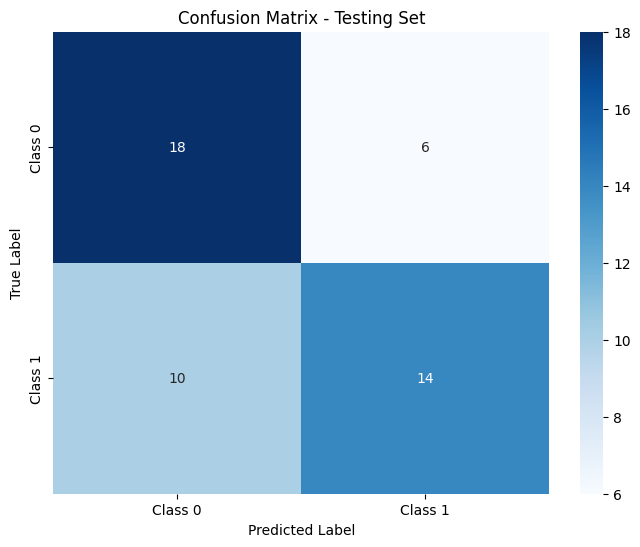


AUC Score: 0.7726


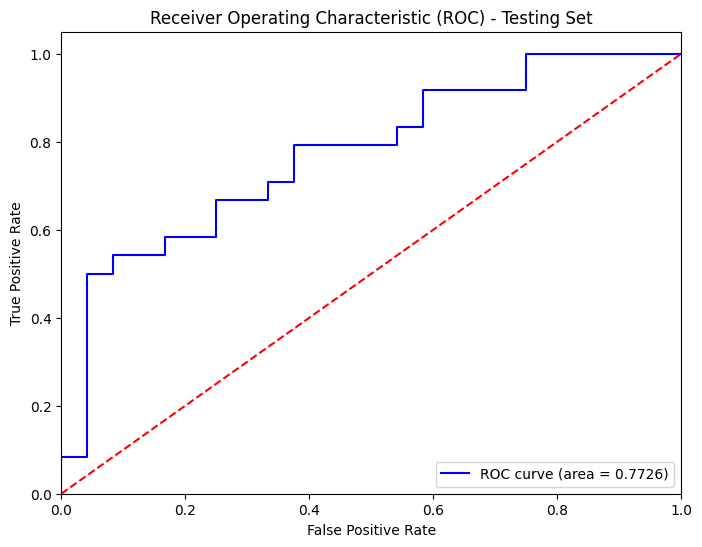


--- Final Run Results ---
{'C': 0.01, 'NumRule': 2, 'NumFuzz': 6, 'NumEnhan': 20, 'TrainingAccuracy': 0.7083333333333334, 'TestingAccuracy': 0.6666666666666666, 'TotalTime': 6.158703327178955}


In [53]:
file_path = '/content/drive/MyDrive/broadlearning/train_data_MLE_imputed_no_negative_med_imputed.csv'

# Load the data
full_data = pd.read_csv(train_file_path)

# Separate features and labels from the full dataset
features = full_data.drop(columns=['batch_label', 'label'])
labels = full_data['label']

# Split the full dataset into an 80/20 train/test (validation) set.
# The `stratify` parameter ensures the class distribution in both sets is the same.
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42
)

print(f"Total data loaded: {len(full_data)} samples")
print(f"Training set size: {len(train_features)} samples (80%)")
print(f"Testing set size: {len(test_features)} samples (20%)")

# Scale features (fit only on training data, transform both train and test)
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)
encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameters for FuzzyBLS ---
C = 0.01      # Regularization parameter
s = 0.8       # Shrinkage parameter
NumRule = 2   # Number of fuzzy rules (clusters) per fuzzy subsystem
NumFuzz = 6   # Number of fuzzy subsystems
NumEnhan = 20 # Number of enhancement nodes

# Initialize Alpha and WeightEnhan for each run to ensure fresh weights
Alpha = []
for i in range(NumFuzz):
    Alpha.append(2 * random.rand(train_features_scaled.shape[1], NumRule) - 1)
WeightEnhan = 2 * random.rand(NumFuzz * NumRule + 1, NumEnhan) - 1

# Call the fuzzy_bls_train function
NetoutTest, Training_time, Testing_time, TrainingAccuracy, TestingAccuracy = \
    fuzzy_bls_train(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot,
                    Alpha, WeightEnhan, s, C, NumRule, NumFuzz)

# Store results
results = {
    'C': C,
    'NumRule': NumRule,
    'NumFuzz': NumFuzz,
    'NumEnhan': NumEnhan,
    'TrainingAccuracy': TrainingAccuracy,
    'TestingAccuracy': TestingAccuracy,
    'TotalTime': Training_time + Testing_time
}
print("\n--- Final Run Results ---")
print(results)

### Left Censored



Total data loaded: 240 samples
Training set size: 192 samples (80%)
Testing set size: 48 samples (20%)
Training has been finished!
The Total Training Time is : 4.801 seconds
Training Accuracy is : 69.792 %
Testing has been finished!
The Total Testing Time is : 0.048 seconds

--- Testing Set Evaluation ---
Overall Accuracy: 64.583%

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.62      0.75      0.68        24
     Class 1       0.68      0.54      0.60        24

    accuracy                           0.65        48
   macro avg       0.65      0.65      0.64        48
weighted avg       0.65      0.65      0.64        48


Confusion Matrix:
[[18  6]
 [11 13]]


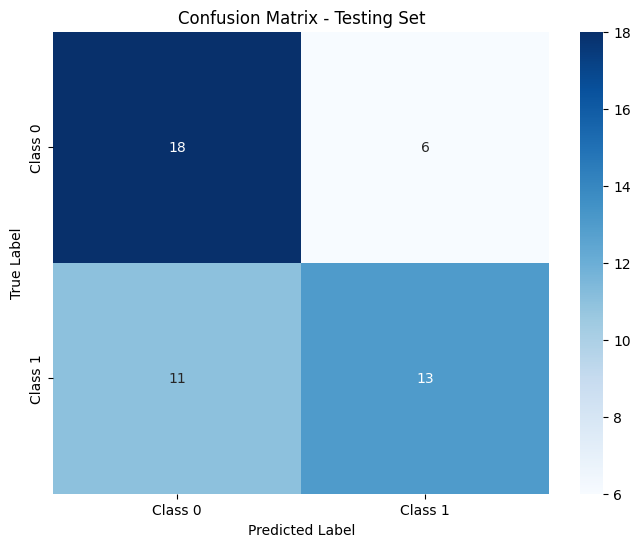


AUC Score: 0.7483


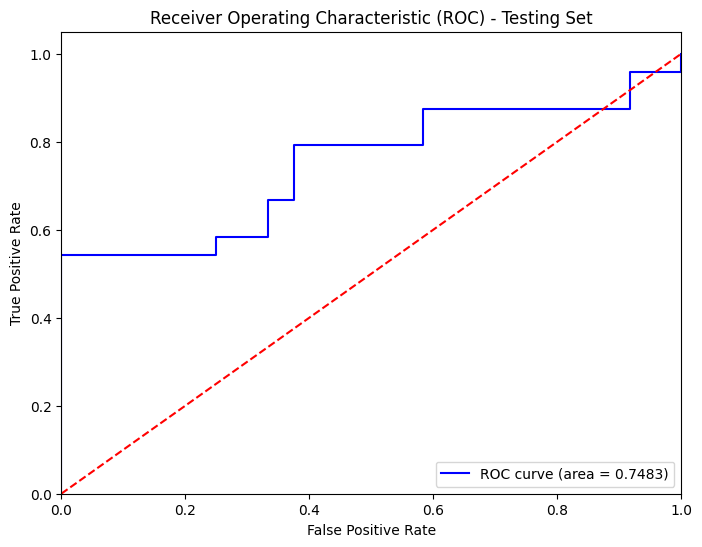


--- Final Run Results ---
{'C': 0.01, 'NumRule': 2, 'NumFuzz': 6, 'NumEnhan': 20, 'TrainingAccuracy': 0.6979166666666666, 'TestingAccuracy': 0.6458333333333334, 'TotalTime': 4.84888482093811}


In [54]:
file_path = '/content/drive/MyDrive/broadlearning/train_data_LeftCensored_imputed.csv'

# Load the data
full_data = pd.read_csv(train_file_path)

# Separate features and labels from the full dataset
features = full_data.drop(columns=['batch_label', 'label'])
labels = full_data['label']

# Split the full dataset into an 80/20 train/test (validation) set.
# The `stratify` parameter ensures the class distribution in both sets is the same.
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42
)

print(f"Total data loaded: {len(full_data)} samples")
print(f"Training set size: {len(train_features)} samples (80%)")
print(f"Testing set size: {len(test_features)} samples (20%)")

# Scale features (fit only on training data, transform both train and test)
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)
encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameters for FuzzyBLS ---
C = 0.01      # Regularization parameter
s = 0.8       # Shrinkage parameter
NumRule = 2   # Number of fuzzy rules (clusters) per fuzzy subsystem
NumFuzz = 6   # Number of fuzzy subsystems
NumEnhan = 20 # Number of enhancement nodes

# Initialize Alpha and WeightEnhan for each run to ensure fresh weights
Alpha = []
for i in range(NumFuzz):
    Alpha.append(2 * random.rand(train_features_scaled.shape[1], NumRule) - 1)
WeightEnhan = 2 * random.rand(NumFuzz * NumRule + 1, NumEnhan) - 1

# Call the fuzzy_bls_train function
NetoutTest, Training_time, Testing_time, TrainingAccuracy, TestingAccuracy = \
    fuzzy_bls_train(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot,
                    Alpha, WeightEnhan, s, C, NumRule, NumFuzz)

# Store results
results = {
    'C': C,
    'NumRule': NumRule,
    'NumFuzz': NumFuzz,
    'NumEnhan': NumEnhan,
    'TrainingAccuracy': TrainingAccuracy,
    'TestingAccuracy': TestingAccuracy,
    'TotalTime': Training_time + Testing_time
}
print("\n--- Final Run Results ---")
print(results)

### RAW data



### KNN



Total data loaded: 240 samples
Training set size: 192 samples (80%)
Testing set size: 48 samples (20%)
Training has been finished!
The Total Training Time is : 2.620 seconds
Training Accuracy is : 63.542 %
Testing has been finished!
The Total Testing Time is : 0.065 seconds

--- Testing Set Evaluation ---
Overall Accuracy: 77.083%

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.72      0.88      0.79        24
     Class 1       0.84      0.67      0.74        24

    accuracy                           0.77        48
   macro avg       0.78      0.77      0.77        48
weighted avg       0.78      0.77      0.77        48


Confusion Matrix:
[[21  3]
 [ 8 16]]


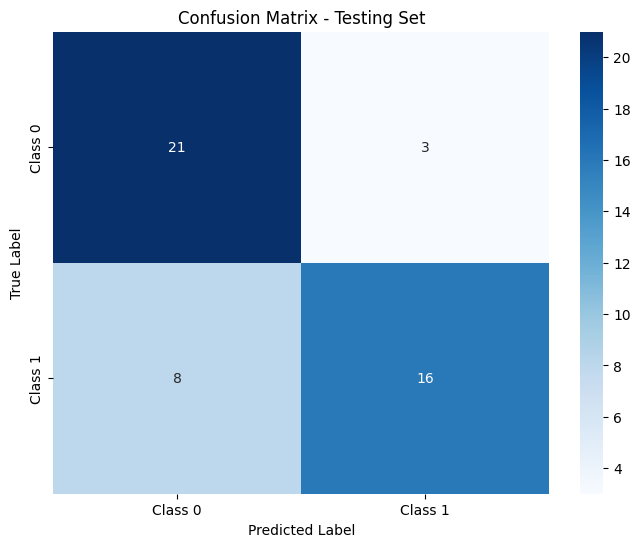


AUC Score: 0.7622


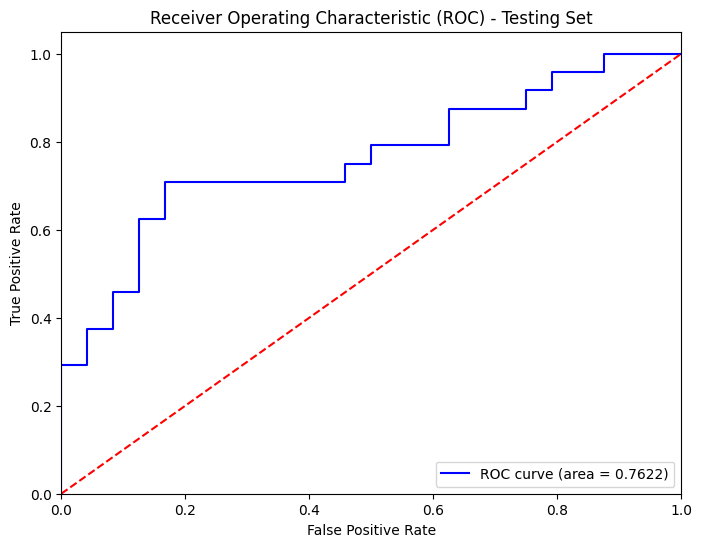


--- Final Run Results ---
{'C': 0.01, 'NumRule': 2, 'NumFuzz': 6, 'NumEnhan': 20, 'TrainingAccuracy': 0.6354166666666666, 'TestingAccuracy': 0.7708333333333334, 'TotalTime': 2.6852853298187256}


In [55]:
file_path = '/content/drive/MyDrive/broadlearning/train_data_KNN_imputed.csv'

# Load the data
full_data = pd.read_csv(train_file_path)

# Separate features and labels from the full dataset
features = full_data.drop(columns=['batch_label', 'label'])
labels = full_data['label']

# Split the full dataset into an 80/20 train/test (validation) set.
# The `stratify` parameter ensures the class distribution in both sets is the same.
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42
)

print(f"Total data loaded: {len(full_data)} samples")
print(f"Training set size: {len(train_features)} samples (80%)")
print(f"Testing set size: {len(test_features)} samples (20%)")

# Scale features (fit only on training data, transform both train and test)
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)
encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameters for FuzzyBLS ---
C = 0.01      # Regularization parameter
s = 0.8       # Shrinkage parameter
NumRule = 2   # Number of fuzzy rules (clusters) per fuzzy subsystem
NumFuzz = 6   # Number of fuzzy subsystems
NumEnhan = 20 # Number of enhancement nodes

# Initialize Alpha and WeightEnhan for each run to ensure fresh weights
Alpha = []
for i in range(NumFuzz):
    Alpha.append(2 * random.rand(train_features_scaled.shape[1], NumRule) - 1)
WeightEnhan = 2 * random.rand(NumFuzz * NumRule + 1, NumEnhan) - 1

# Call the fuzzy_bls_train function
NetoutTest, Training_time, Testing_time, TrainingAccuracy, TestingAccuracy = \
    fuzzy_bls_train(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot,
                    Alpha, WeightEnhan, s, C, NumRule, NumFuzz)

# Store results
results = {
    'C': C,
    'NumRule': NumRule,
    'NumFuzz': NumFuzz,
    'NumEnhan': NumEnhan,
    'TrainingAccuracy': TrainingAccuracy,
    'TestingAccuracy': TestingAccuracy,
    'TotalTime': Training_time + Testing_time
}
print("\n--- Final Run Results ---")
print(results)

### SVD

Total data loaded: 240 samples
Training set size: 192 samples (80%)
Testing set size: 48 samples (20%)
Training has been finished!
The Total Training Time is : 4.288 seconds
Training Accuracy is : 65.104 %
Testing has been finished!
The Total Testing Time is : 0.079 seconds

--- Testing Set Evaluation ---
Overall Accuracy: 72.917%

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.68      0.88      0.76        24
     Class 1       0.82      0.58      0.68        24

    accuracy                           0.73        48
   macro avg       0.75      0.73      0.72        48
weighted avg       0.75      0.73      0.72        48


Confusion Matrix:
[[21  3]
 [10 14]]


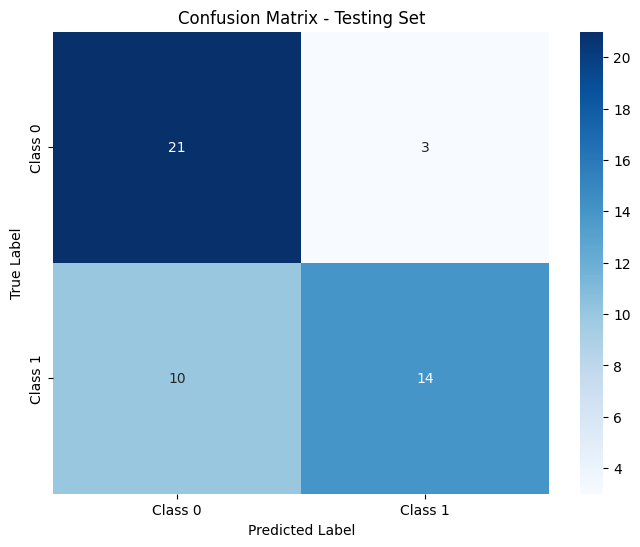


AUC Score: 0.7969


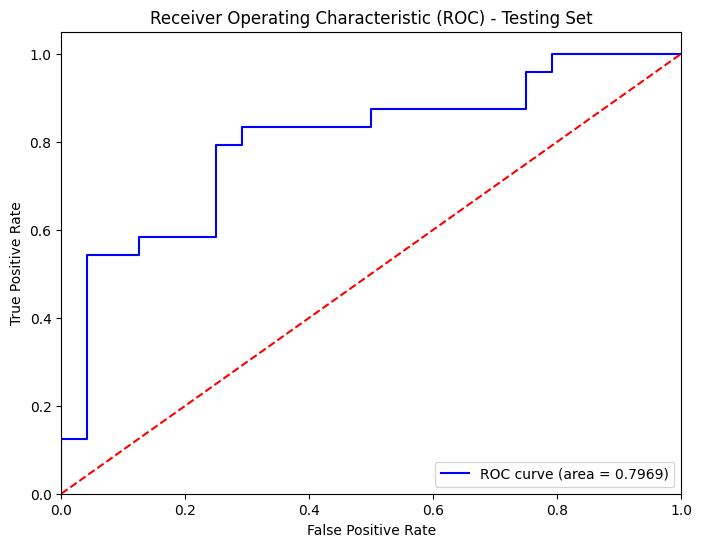


--- Final Run Results ---
{'C': 0.01, 'NumRule': 2, 'NumFuzz': 6, 'NumEnhan': 20, 'TrainingAccuracy': 0.6510416666666666, 'TestingAccuracy': 0.7291666666666666, 'TotalTime': 4.367150545120239}


In [56]:
file_path = '/content/drive/MyDrive/broadlearning/Train_data_Imputed_SVD_no_negative.csv'

# Load the data
full_data = pd.read_csv(train_file_path)

# Separate features and labels from the full dataset
features = full_data.drop(columns=['batch_label', 'label'])
labels = full_data['label']

# Split the full dataset into an 80/20 train/test (validation) set.
# The `stratify` parameter ensures the class distribution in both sets is the same.
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42
)

print(f"Total data loaded: {len(full_data)} samples")
print(f"Training set size: {len(train_features)} samples (80%)")
print(f"Testing set size: {len(test_features)} samples (20%)")

# Scale features (fit only on training data, transform both train and test)
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)
encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameters for FuzzyBLS ---
C = 0.01      # Regularization parameter
s = 0.8       # Shrinkage parameter
NumRule = 2   # Number of fuzzy rules (clusters) per fuzzy subsystem
NumFuzz = 6   # Number of fuzzy subsystems
NumEnhan = 20 # Number of enhancement nodes

# Initialize Alpha and WeightEnhan for each run to ensure fresh weights
Alpha = []
for i in range(NumFuzz):
    Alpha.append(2 * random.rand(train_features_scaled.shape[1], NumRule) - 1)
WeightEnhan = 2 * random.rand(NumFuzz * NumRule + 1, NumEnhan) - 1

# Call the fuzzy_bls_train function
NetoutTest, Training_time, Testing_time, TrainingAccuracy, TestingAccuracy = \
    fuzzy_bls_train(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot,
                    Alpha, WeightEnhan, s, C, NumRule, NumFuzz)

# Store results
results = {
    'C': C,
    'NumRule': NumRule,
    'NumFuzz': NumFuzz,
    'NumEnhan': NumEnhan,
    'TrainingAccuracy': TrainingAccuracy,
    'TestingAccuracy': TestingAccuracy,
    'TotalTime': Training_time + Testing_time
}
print("\n--- Final Run Results ---")
print(results)

### BPCA


Total data loaded: 240 samples
Training set size: 192 samples (80%)
Testing set size: 48 samples (20%)
Training has been finished!
The Total Training Time is : 5.454 seconds
Training Accuracy is : 69.271 %
Testing has been finished!
The Total Testing Time is : 0.037 seconds

--- Testing Set Evaluation ---
Overall Accuracy: 68.750%

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.68      0.71      0.69        24
     Class 1       0.70      0.67      0.68        24

    accuracy                           0.69        48
   macro avg       0.69      0.69      0.69        48
weighted avg       0.69      0.69      0.69        48


Confusion Matrix:
[[17  7]
 [ 8 16]]


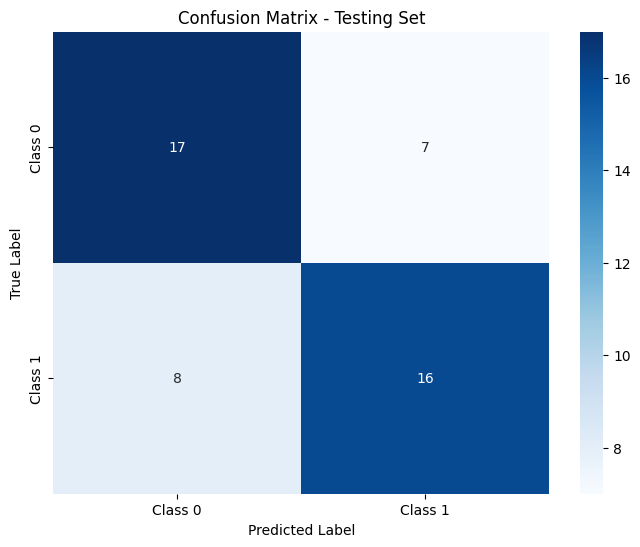


AUC Score: 0.7795


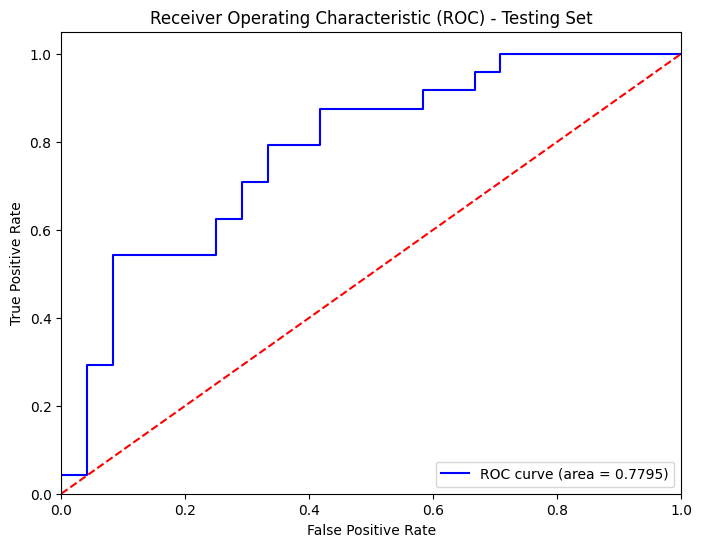


--- Final Run Results ---
{'C': 0.01, 'NumRule': 2, 'NumFuzz': 6, 'NumEnhan': 20, 'TrainingAccuracy': 0.6927083333333334, 'TestingAccuracy': 0.6875, 'TotalTime': 5.4905548095703125}


In [57]:
file_path = '/content/drive/MyDrive/broadlearning/train_data_BPCA_imputed.csv'

# Load the data
full_data = pd.read_csv(train_file_path)

# Separate features and labels from the full dataset
features = full_data.drop(columns=['batch_label', 'label'])
labels = full_data['label']

# Split the full dataset into an 80/20 train/test (validation) set.
# The `stratify` parameter ensures the class distribution in both sets is the same.
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42
)

print(f"Total data loaded: {len(full_data)} samples")
print(f"Training set size: {len(train_features)} samples (80%)")
print(f"Testing set size: {len(test_features)} samples (20%)")

# Scale features (fit only on training data, transform both train and test)
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)
encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameters for FuzzyBLS ---
C = 0.01      # Regularization parameter
s = 0.8       # Shrinkage parameter
NumRule = 2   # Number of fuzzy rules (clusters) per fuzzy subsystem
NumFuzz = 6   # Number of fuzzy subsystems
NumEnhan = 20 # Number of enhancement nodes

# Initialize Alpha and WeightEnhan for each run to ensure fresh weights
Alpha = []
for i in range(NumFuzz):
    Alpha.append(2 * random.rand(train_features_scaled.shape[1], NumRule) - 1)
WeightEnhan = 2 * random.rand(NumFuzz * NumRule + 1, NumEnhan) - 1

# Call the fuzzy_bls_train function
NetoutTest, Training_time, Testing_time, TrainingAccuracy, TestingAccuracy = \
    fuzzy_bls_train(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot,
                    Alpha, WeightEnhan, s, C, NumRule, NumFuzz)

# Store results
results = {
    'C': C,
    'NumRule': NumRule,
    'NumFuzz': NumFuzz,
    'NumEnhan': NumEnhan,
    'TrainingAccuracy': TrainingAccuracy,
    'TestingAccuracy': TestingAccuracy,
    'TotalTime': Training_time + Testing_time
}
print("\n--- Final Run Results ---")
print(results)

### AE



Total data loaded: 240 samples
Training set size: 192 samples (80%)
Testing set size: 48 samples (20%)
Training has been finished!
The Total Training Time is : 5.708 seconds
Training Accuracy is : 65.625 %
Testing has been finished!
The Total Testing Time is : 0.043 seconds

--- Testing Set Evaluation ---
Overall Accuracy: 62.500%

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.61      0.71      0.65        24
     Class 1       0.65      0.54      0.59        24

    accuracy                           0.62        48
   macro avg       0.63      0.62      0.62        48
weighted avg       0.63      0.62      0.62        48


Confusion Matrix:
[[17  7]
 [11 13]]


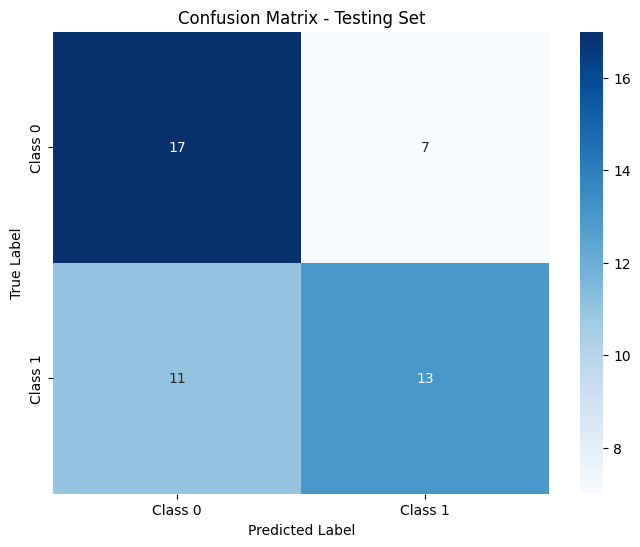


AUC Score: 0.6007


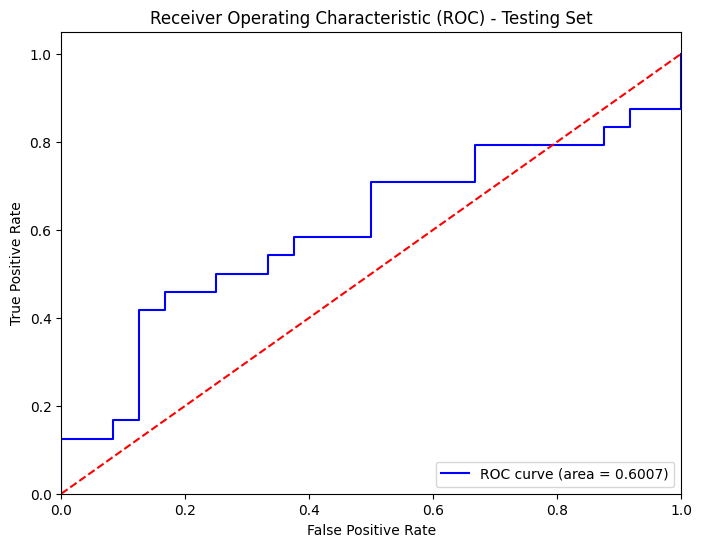


--- Final Run Results ---
{'C': 0.01, 'NumRule': 2, 'NumFuzz': 6, 'NumEnhan': 20, 'TrainingAccuracy': 0.65625, 'TestingAccuracy': 0.625, 'TotalTime': 5.7508227825164795}


In [58]:
file_path = '/content/drive/MyDrive/broadlearning/train_data_AE_imputed.csv'

# Load the data
full_data = pd.read_csv(train_file_path)

# Separate features and labels from the full dataset
features = full_data.drop(columns=['batch_label', 'label'])
labels = full_data['label']

# Split the full dataset into an 80/20 train/test (validation) set.
# The `stratify` parameter ensures the class distribution in both sets is the same.
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42
)

print(f"Total data loaded: {len(full_data)} samples")
print(f"Training set size: {len(train_features)} samples (80%)")
print(f"Testing set size: {len(test_features)} samples (20%)")

# Scale features (fit only on training data, transform both train and test)
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)
encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameters for FuzzyBLS ---
C = 0.01      # Regularization parameter
s = 0.8       # Shrinkage parameter
NumRule = 2   # Number of fuzzy rules (clusters) per fuzzy subsystem
NumFuzz = 6   # Number of fuzzy subsystems
NumEnhan = 20 # Number of enhancement nodes

# Initialize Alpha and WeightEnhan for each run to ensure fresh weights
Alpha = []
for i in range(NumFuzz):
    Alpha.append(2 * random.rand(train_features_scaled.shape[1], NumRule) - 1)
WeightEnhan = 2 * random.rand(NumFuzz * NumRule + 1, NumEnhan) - 1

# Call the fuzzy_bls_train function
NetoutTest, Training_time, Testing_time, TrainingAccuracy, TestingAccuracy = \
    fuzzy_bls_train(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot,
                    Alpha, WeightEnhan, s, C, NumRule, NumFuzz)

# Store results
results = {
    'C': C,
    'NumRule': NumRule,
    'NumFuzz': NumFuzz,
    'NumEnhan': NumEnhan,
    'TrainingAccuracy': TrainingAccuracy,
    'TestingAccuracy': TestingAccuracy,
    'TotalTime': Training_time + Testing_time
}
print("\n--- Final Run Results ---")
print(results)

### VAE


Total data loaded: 240 samples
Training set size: 192 samples (80%)
Testing set size: 48 samples (20%)
Training has been finished!
The Total Training Time is : 4.515 seconds
Training Accuracy is : 66.146 %
Testing has been finished!
The Total Testing Time is : 0.071 seconds

--- Testing Set Evaluation ---
Overall Accuracy: 72.917%

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.72      0.75      0.73        24
     Class 1       0.74      0.71      0.72        24

    accuracy                           0.73        48
   macro avg       0.73      0.73      0.73        48
weighted avg       0.73      0.73      0.73        48


Confusion Matrix:
[[18  6]
 [ 7 17]]


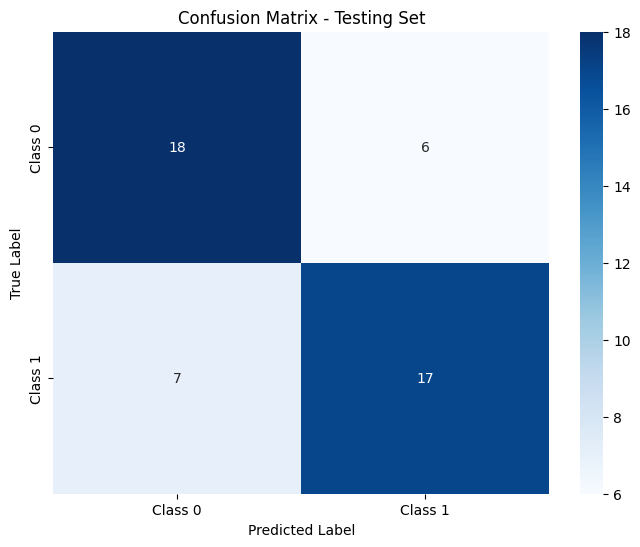


AUC Score: 0.7708


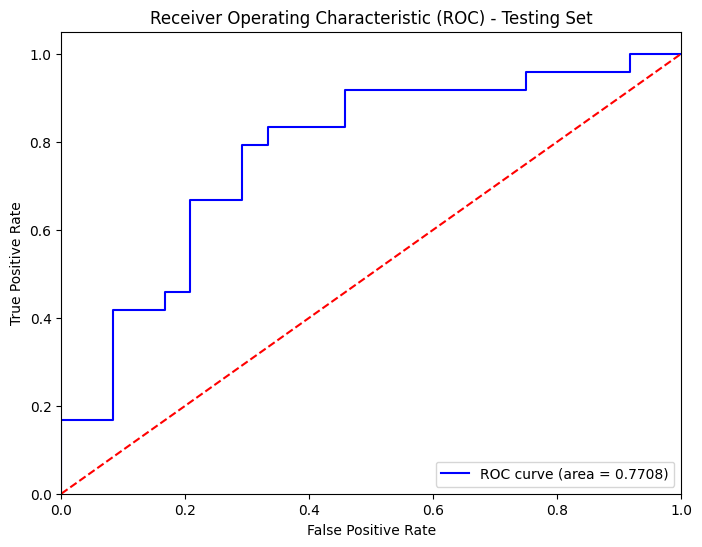


--- Final Run Results ---
{'C': 0.01, 'NumRule': 2, 'NumFuzz': 6, 'NumEnhan': 20, 'TrainingAccuracy': 0.6614583333333334, 'TestingAccuracy': 0.7291666666666666, 'TotalTime': 4.585575103759766}


In [59]:
file_path = '/content/drive/MyDrive/broadlearning/ImputedVAETrain_common.csv'

# Load the data
full_data = pd.read_csv(train_file_path)

# Separate features and labels from the full dataset
features = full_data.drop(columns=['batch_label', 'label'])
labels = full_data['label']

# Split the full dataset into an 80/20 train/test (validation) set.
# The `stratify` parameter ensures the class distribution in both sets is the same.
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42
)

print(f"Total data loaded: {len(full_data)} samples")
print(f"Training set size: {len(train_features)} samples (80%)")
print(f"Testing set size: {len(test_features)} samples (20%)")

# Scale features (fit only on training data, transform both train and test)
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)
encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameters for FuzzyBLS ---
C = 0.01      # Regularization parameter
s = 0.8       # Shrinkage parameter
NumRule = 2   # Number of fuzzy rules (clusters) per fuzzy subsystem
NumFuzz = 6   # Number of fuzzy subsystems
NumEnhan = 20 # Number of enhancement nodes

# Initialize Alpha and WeightEnhan for each run to ensure fresh weights
Alpha = []
for i in range(NumFuzz):
    Alpha.append(2 * random.rand(train_features_scaled.shape[1], NumRule) - 1)
WeightEnhan = 2 * random.rand(NumFuzz * NumRule + 1, NumEnhan) - 1

# Call the fuzzy_bls_train function
NetoutTest, Training_time, Testing_time, TrainingAccuracy, TestingAccuracy = \
    fuzzy_bls_train(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot,
                    Alpha, WeightEnhan, s, C, NumRule, NumFuzz)

# Store results
results = {
    'C': C,
    'NumRule': NumRule,
    'NumFuzz': NumFuzz,
    'NumEnhan': NumEnhan,
    'TrainingAccuracy': TrainingAccuracy,
    'TestingAccuracy': TestingAccuracy,
    'TotalTime': Training_time + Testing_time
}
print("\n--- Final Run Results ---")
print(results)

### DAE

Total data loaded: 240 samples
Training set size: 192 samples (80%)
Testing set size: 48 samples (20%)
Training has been finished!
The Total Training Time is : 5.841 seconds
Training Accuracy is : 69.792 %
Testing has been finished!
The Total Testing Time is : 0.059 seconds

--- Testing Set Evaluation ---
Overall Accuracy: 68.750%

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.67      0.75      0.71        24
     Class 1       0.71      0.62      0.67        24

    accuracy                           0.69        48
   macro avg       0.69      0.69      0.69        48
weighted avg       0.69      0.69      0.69        48


Confusion Matrix:
[[18  6]
 [ 9 15]]


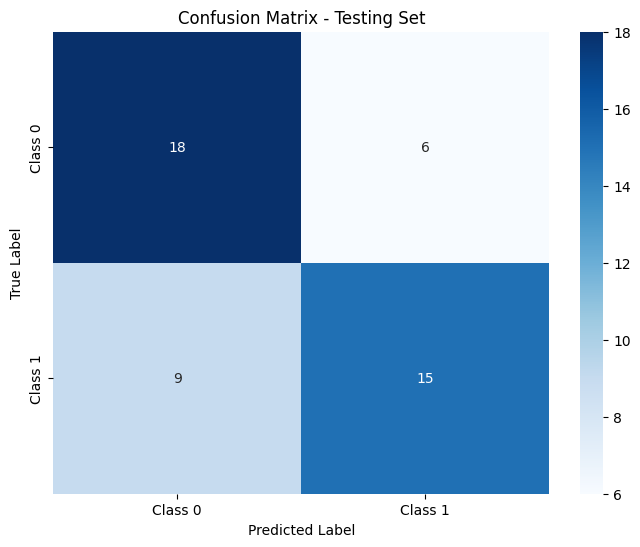


AUC Score: 0.7153


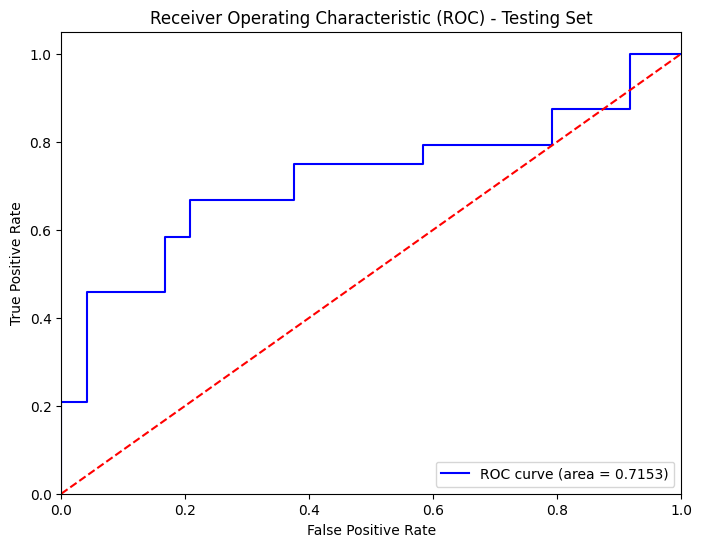


--- Final Run Results ---
{'C': 0.01, 'NumRule': 2, 'NumFuzz': 6, 'NumEnhan': 20, 'TrainingAccuracy': 0.6979166666666666, 'TestingAccuracy': 0.6875, 'TotalTime': 5.90047550201416}


In [60]:
file_path = '/content/drive/MyDrive/broadlearning/ImputedDAETrain_common.csv'

# Load the data
full_data = pd.read_csv(train_file_path)

# Separate features and labels from the full dataset
features = full_data.drop(columns=['batch_label', 'label'])
labels = full_data['label']

# Split the full dataset into an 80/20 train/test (validation) set.
# The `stratify` parameter ensures the class distribution in both sets is the same.
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42
)

print(f"Total data loaded: {len(full_data)} samples")
print(f"Training set size: {len(train_features)} samples (80%)")
print(f"Testing set size: {len(test_features)} samples (20%)")

# Scale features (fit only on training data, transform both train and test)
scaler = preprocessing.StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.transform(test_features)

# Reshape and one-hot encode the labels
train_labels_reshaped = train_labels.values.reshape(-1, 1)
test_labels_reshaped = test_labels.values.reshape(-1, 1)
encoder = preprocessing.OneHotEncoder(sparse_output=False, categories='auto')
train_labels_onehot = encoder.fit_transform(train_labels_reshaped)
test_labels_onehot = encoder.transform(test_labels_reshaped)

# --- Hyperparameters for FuzzyBLS ---
C = 0.01      # Regularization parameter
s = 0.8       # Shrinkage parameter
NumRule = 2   # Number of fuzzy rules (clusters) per fuzzy subsystem
NumFuzz = 6   # Number of fuzzy subsystems
NumEnhan = 20 # Number of enhancement nodes

# Initialize Alpha and WeightEnhan for each run to ensure fresh weights
Alpha = []
for i in range(NumFuzz):
    Alpha.append(2 * random.rand(train_features_scaled.shape[1], NumRule) - 1)
WeightEnhan = 2 * random.rand(NumFuzz * NumRule + 1, NumEnhan) - 1

# Call the fuzzy_bls_train function
NetoutTest, Training_time, Testing_time, TrainingAccuracy, TestingAccuracy = \
    fuzzy_bls_train(train_features_scaled, train_labels_onehot, test_features_scaled, test_labels_onehot,
                    Alpha, WeightEnhan, s, C, NumRule, NumFuzz)

# Store results
results = {
    'C': C,
    'NumRule': NumRule,
    'NumFuzz': NumFuzz,
    'NumEnhan': NumEnhan,
    'TrainingAccuracy': TrainingAccuracy,
    'TestingAccuracy': TestingAccuracy,
    'TotalTime': Training_time + Testing_time
}
print("\n--- Final Run Results ---")
print(results)